In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import time
import copy
from tqdm.auto import tqdm
from IPython.display import clear_output

In [4]:
def plot_results(b, m, w, yhigh = 0):
    plt.figure(figsize=(14, 5))
    if yhigh > 0:
        plt.ylim(0, yhigh)
    plt.title(f"Population data in each iteration")
    plt.plot(b, label = "Best")
    plt.plot(m, label = "Mean")
    plt.plot(w, label = "Worst")
    no_iters = len(b)
    xs = np.array([i for i in range(no_iters)])
    ys = np.array([0 for i in range(no_iters)])
    plt.plot(xs, ys)
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
    
#     plt.figure()
#     plt.title(f"Best values")
#     plt.hist(b, bins = 20)
    plt.show()

In [4]:
def plot_sigmas(sigmas):
    plt.figure(figsize=(14, 5))
    plt.title(f"Sigmas data in each iteration")
    plt.plot(sigmas, label = "Mean of sigmas")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
    plt.show()

In [6]:
class ES:
    def __init__(self, 
                 no_iterations, 
                 mu, l, d, K,
                 problem_class,
                 verbose = False,
                 population_choosing_method = 'just_offspring',
                 parents_selection_method = 'roulette'):
        '''
        Args:
            no_iterations: number of iterations algorithm should execute in run() method
            mu: population size
            l: offspring size
            d: individual size
            K: mutation parameter used to computate t and t0
            random_pop_function: function that generates random population
            objective_function: function that evaluates an individual
            population_choosing_method: 'sum' for (mu + lambda), 'just_parents' for (mu, lambda)
            parents_selection_method: 'roulette', 'reversed_roulette' (min-max nomralization), 'random'

        '''
        self.no_iterations = no_iterations
        self.mu = mu
        self.l = l
        self.d = d
        self.problem = problem_class
        self.population = self.random_population(self.mu)
        self.sigmas_population = self.problem.random_sigmas_population(d, mu)
        self.population_vals = self.evaluate_population(self.population)
        self.t = K / np.sqrt(2*d)
        self.t0 = K / np.sqrt(2*np.sqrt(d))
        self.i = 0
        self.population_choosing_method = population_choosing_method
        self.verbose = verbose
        self.best = []
        self.mean = []
        self.worst = []
        self.sigmas_mean = []
        if parents_selection_method == 'roulette':
            self.parents_selection_method = self.roulette
        elif parents_selection_method == 'random':
            self.parents_selection_method = self.all_random
        elif parents_selection_method == 'reversed_roulette':
            self.parents_selection_method = self.reversed_roulette
        
    def random_population(self, N):
        return self.problem.random_population(self.d, N)
    
    def evaluate_individual(self, individual):
        return self.problem.objective_function(individual)
    
    def evaluate_population(self, population):
        return np.array([self.evaluate_individual(individual) for individual in population])
    
    def mutate(self, population, sigmas_population):
        for i in range(population.shape[0]):
            random_t0 = np.random.normal(scale = self.t0)
            sigmas_population[i] *= np.exp(np.random.normal(scale = self.t, size = self.d) + random_t0)
            population[i] += np.random.normal(scale = sigmas_population[i], size = self.d)
            
            ## fixing any genes that went outisde their range
#             for j in range(self.d):
#                 while population[i][j] > self.problem.high or population[i][j] < self.problem.low:
#                     if population[i][j] > self.problem.high:
#                         population[i][j] -= (population[i][j] - self.problem.high)
#                     if population[i][j] < self.problem.low:
#                         population[i][j] += (self.problem.low - population[i][j])
        return population, sigmas_population                            
    
    
    def roulette(self, population, sigmas_population, population_vals):
        N = population.shape[0]
        vals = -(population_vals - np.max(population_vals))
        sum_of_vals = np.sum(vals)
        if sum_of_vals == 0:
            probs = np.ones(N) / N
        else:
            probs = vals / sum_of_vals
        random_indices = np.random.choice(a = N, 
                               size = self.l, 
                               replace = True, 
                               p = probs)
        return population[random_indices], sigmas_population[random_indices],
        
        
    def reversed_roulette(self, population, sigmas_population, population_vals):
        # Min-max normalization
        N = population.shape[0]
        if abs(population_vals.max() - population_vals.min()) > 0.01:
            probs = (population_vals - population_vals.min())/(population_vals.max() - population_vals.min())
        else:
            probs = population_vals
        probs /= probs.sum()
        random_indices = np.random.choice(a = N, 
                                           size = self.l, 
                                           replace = True, 
                                           p = probs)
        return population[random_indices], sigmas_population[random_indices],
    
    def all_random(self, population, sigmas_population, population_vals):
        N = population.shape[0]
        random_indices = np.random.choice(a = N, 
                                           size = self.l, 
                                           replace = True)
        return population[random_indices], sigmas_population[random_indices],
    
    def choose_parents(self, population, sigmas_population, population_vals):
        return self.parents_selection_method(population, sigmas_population, population_vals)
               
    def generate_new_population(self, children, children_vals, children_sigmas):
        if self.population_choosing_method == 'sum':
            all_individuals = np.vstack((children, self.population))
            all_vals = np.concatenate((children_vals, self.population_vals))
            all_sigmas = np.vstack((children_sigmas, self.sigmas_population))
            best_indices = np.argsort(all_vals)[:self.mu]
            self.population = all_individuals[best_indices]
            self.population_vals = all_vals[best_indices]
            self.sigmas_population = all_sigmas[best_indices]       
        elif self.population_choosing_method == 'just_offspring':
            best_indices = np.argsort(children_vals)[:self.mu]
            self.population = children[best_indices]
            self.population_vals = children_vals[best_indices]
            self.sigmas_population = children_sigmas[best_indices]
        
    def do_iteration(self):
        parents, parents_sigmas = self.choose_parents(self.population, self.sigmas_population, self.population_vals)
        children, children_sigmas = self.mutate(parents, parents_sigmas)
        children_vals = self.evaluate_population(children)
        self.generate_new_population(children, children_vals, children_sigmas)
        
    def run(self):
        for self.i in tqdm(range(self.no_iterations)):
            self.do_iteration()
            self.best.append(np.min(self.population_vals))
            self.mean.append(np.mean(self.population_vals))
            self.worst.append(np.max(self.population_vals))
            self.sigmas_mean.append(np.mean(self.sigmas_population))
            #if (self.i+1) % 200 == 0 or self.i == 0 or self.i == self.no_iterations-1:
               # print(f"Iteration {self.i+1}. Current min: ", np.min(self.population_vals))

In [9]:
def test(problem, selection, iters=1000):
    for i in range(2):
        if i == 0:
            print("Mu + Lambda")
            method = 'sum'
        else:
            print("Mu, Lambda")
            method = 'just_offspring'
        for D in [10, 50, 100]:
            print(f"no_iterations = {iters}, mu = 800, l = 2000, d = {D}, K = 0.6, {method}")
            
            es = ES (no_iterations = iters, mu = 800, l = 2000, d = D, K = 0.6, problem_class = problem,
            population_choosing_method=method, parents_selection_method = selection)
            es.run()
            plot_results(es.best, es.mean, es.worst, yhigh = 2 * np.max(es.best))
            plot_sigmas(es.sigmas_mean)

# 1b)
Zapoznaj się z popularnymi benchmarkami dla optymalizacji globalnej (http://wwwoptima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO.htm), zarówno
problemami optymalizacji bez ograniczeń jak i z ograniczeniami. Wybierz 5 benchmarków
bez ograniczeń i użyj zaimplementowanych algorytmów do ich rozwiązywania (wśród
wybranych benchmarków powinna znaleźć się co najmniej jedna z następujących funkcji:
Griewank Function, Rastrigin Function, Schwefel Function). Dokładnie przeanalizuj
działanie algorytmu i otrzymane wyniki. Sprawdź różne ustawienia algorytmu. 


## Sphere Function
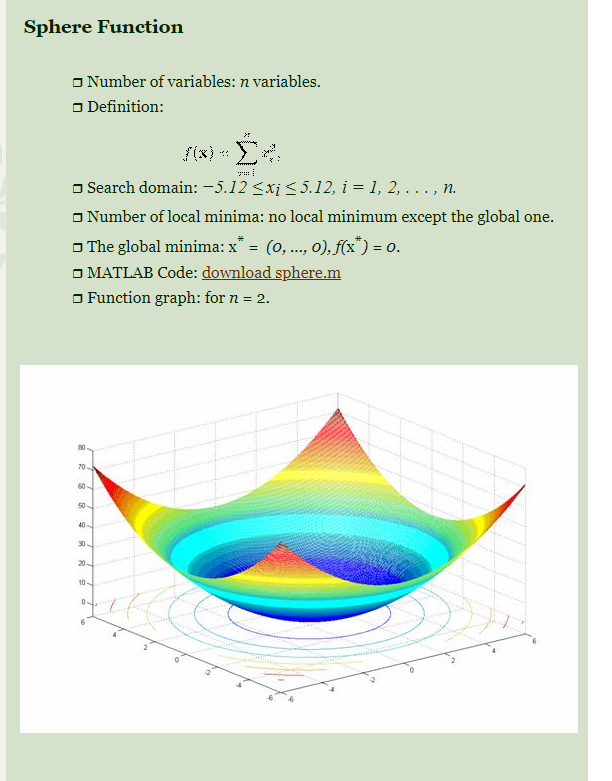

In [5]:
class SphereFunction:
    low = -5.12
    high = 5.12
    low_sigma = 0
    high_sigma = 0.5
    
    def objective_function(ind):
        return np.sum(ind**2)
        
    def random_population(d, N):
        return np.random.uniform(low = SphereFunction.low, high = SphereFunction.high, size = (N, d))
    
    def random_sigmas_population(d, N):
        return np.random.uniform(high = SphereFunction.high_sigma, size = (N, d))

Mu + Lambda
no_iterations = 1400, mu = 800, l = 2000, d = 10, K = 0.6, sum


Iteration 1. Current min:  21.03783993537511
Iteration 100. Current min:  8.139441881193126e-12
Iteration 200. Current min:  3.731293088113857e-25
Iteration 300. Current min:  3.2108518913612802e-37
Iteration 400. Current min:  1.966655612688707e-46
Iteration 500. Current min:  3.535637188448574e-59
Iteration 600. Current min:  1.4700089323531705e-72
Iteration 700. Current min:  1.6734631366028122e-84
Iteration 800. Current min:  3.844758364812213e-97
Iteration 900. Current min:  2.0782069361722106e-109
Iteration 1000. Current min:  3.138514734949739e-120
Iteration 1100. Current min:  1.6484629090133922e-131
Iteration 1200. Current min:  5.987846424701261e-144
Iteration 1300. Current min:  4.55769241947735e-155
Iteration 1400. Current min:  1.9580473608321492e-166



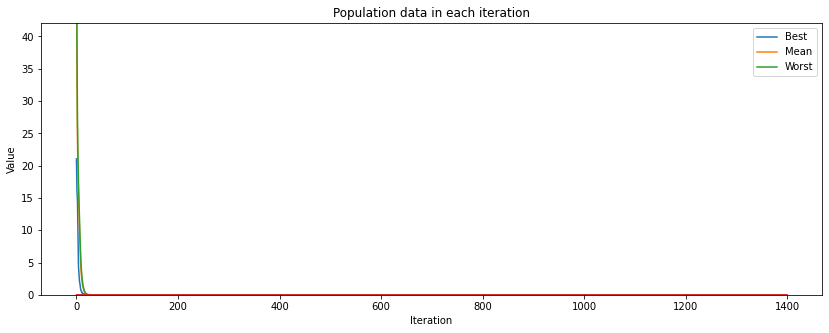

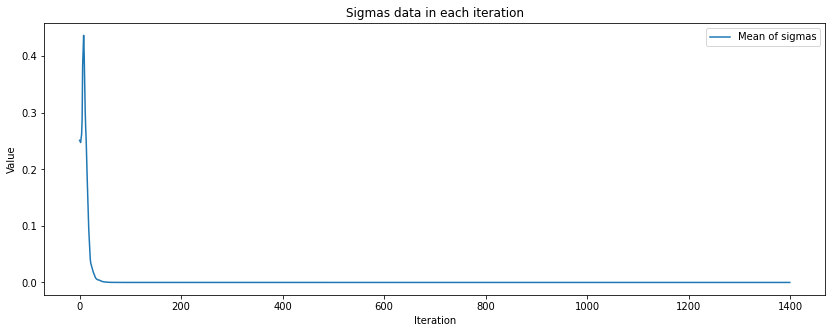

no_iterations = 1400, mu = 800, l = 2000, d = 50, K = 0.6, sum


Iteration 1. Current min:  260.38301720074577
Iteration 100. Current min:  27.766204026739643
Iteration 200. Current min:  8.453634478574308
Iteration 300. Current min:  2.021540443692766
Iteration 400. Current min:  0.5137146274218267
Iteration 500. Current min:  0.1254673608883216
Iteration 600. Current min:  0.0025502588023380442
Iteration 700. Current min:  0.0003211772782340205
Iteration 800. Current min:  5.443591574338744e-05
Iteration 900. Current min:  1.268701517857397e-05
Iteration 1000. Current min:  2.1268030357165405e-06
Iteration 1100. Current min:  1.5437997765545817e-06
Iteration 1200. Current min:  1.4336718573696797e-06
Iteration 1300. Current min:  1.2264529732331945e-06
Iteration 1400. Current min:  9.871654966967856e-07



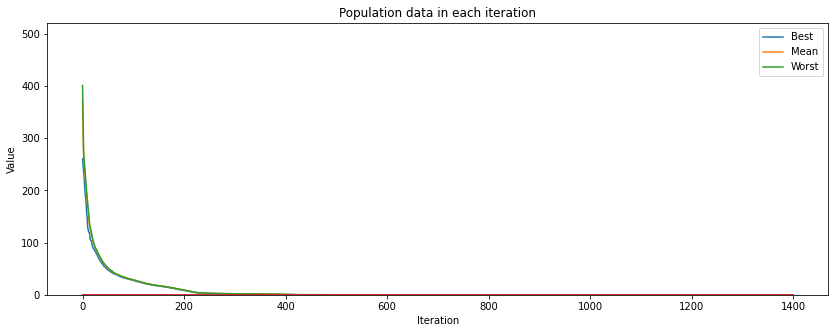

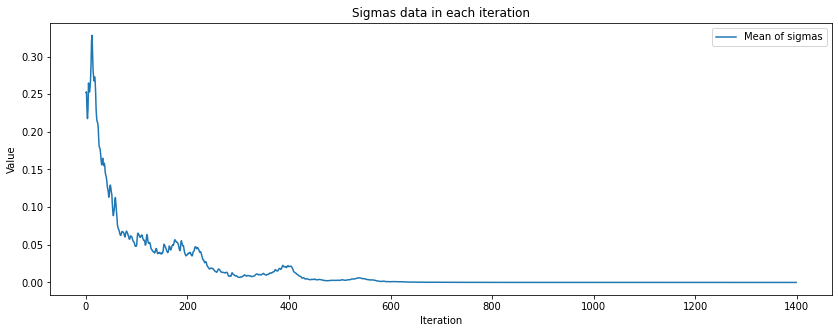

no_iterations = 1400, mu = 800, l = 2000, d = 100, K = 0.6, sum


Iteration 1. Current min:  624.7759164710618
Iteration 100. Current min:  120.91614997733687
Iteration 200. Current min:  72.07718908736987
Iteration 300. Current min:  54.403136398592615
Iteration 400. Current min:  50.432506214246814
Iteration 500. Current min:  48.54968111671109
Iteration 600. Current min:  44.92400653304762
Iteration 700. Current min:  29.940004131837227
Iteration 800. Current min:  29.264554064842255
Iteration 900. Current min:  28.559818038488714
Iteration 1000. Current min:  26.90669973532606
Iteration 1100. Current min:  26.540638507005028
Iteration 1200. Current min:  25.631825448839905
Iteration 1300. Current min:  8.311291542477035
Iteration 1400. Current min:  5.4666124968057925



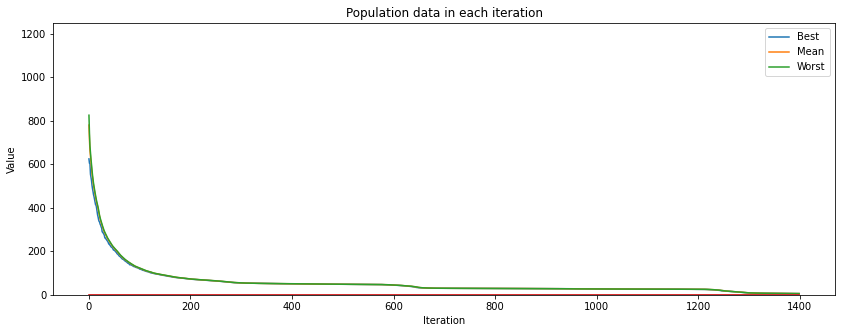

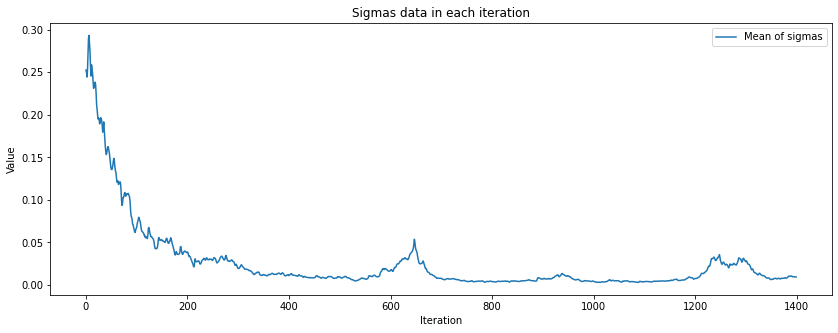

Mu, Lambda
no_iterations = 1400, mu = 800, l = 2000, d = 10, K = 0.6, just_offspring


Iteration 1. Current min:  23.701897669308888
Iteration 100. Current min:  1.414801687568572e-08
Iteration 200. Current min:  4.009661863328887e-19
Iteration 300. Current min:  3.094774137220305e-29
Iteration 400. Current min:  3.315492851975455e-39
Iteration 500. Current min:  5.366464541712372e-51
Iteration 600. Current min:  1.638792749042639e-61
Iteration 700. Current min:  1.9324054118612858e-72
Iteration 800. Current min:  2.2467363864852974e-84
Iteration 900. Current min:  9.989238740978729e-96
Iteration 1000. Current min:  6.936417075146471e-107
Iteration 1100. Current min:  6.104427452966777e-118
Iteration 1200. Current min:  5.2063361701268855e-129
Iteration 1300. Current min:  5.111931486590746e-141
Iteration 1400. Current min:  1.4673748934480153e-150



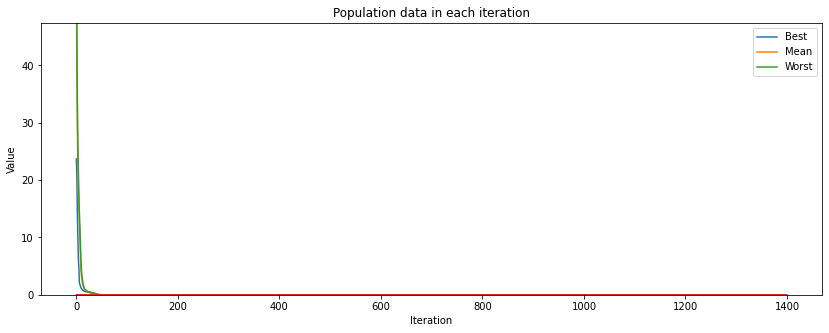

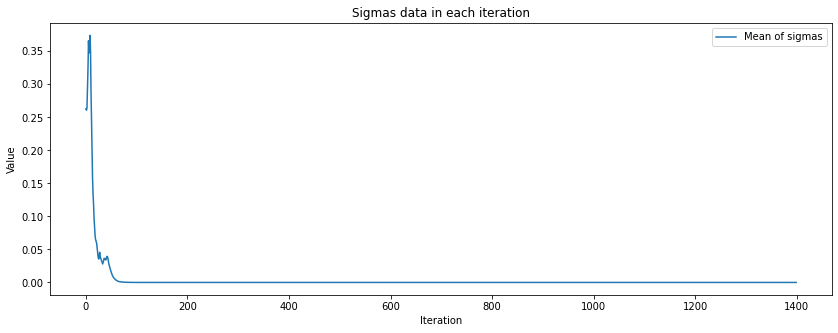

no_iterations = 1400, mu = 800, l = 2000, d = 50, K = 0.6, just_offspring


Iteration 1. Current min:  252.43543335284195
Iteration 100. Current min:  17.136351093281228
Iteration 200. Current min:  3.4871357522586495
Iteration 300. Current min:  2.2505284276310484
Iteration 400. Current min:  0.4952631041255752
Iteration 500. Current min:  0.16018243279912572
Iteration 600. Current min:  0.03499061440126386
Iteration 700. Current min:  0.003609307283022947
Iteration 800. Current min:  0.000582817760141195
Iteration 900. Current min:  0.00017021474279270055
Iteration 1000. Current min:  6.27467790052197e-05
Iteration 1100. Current min:  1.8199015139217326e-05
Iteration 1200. Current min:  7.68186426696569e-06
Iteration 1300. Current min:  4.919533639988029e-06
Iteration 1400. Current min:  1.2451925558307294e-06



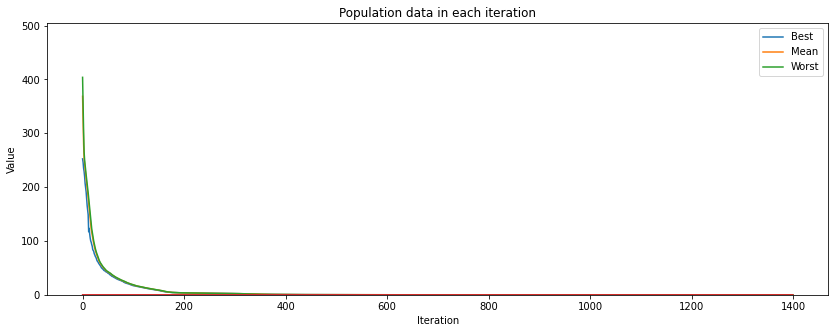

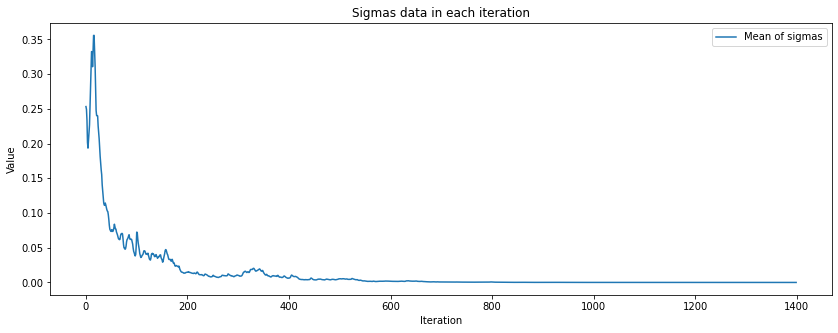

no_iterations = 1400, mu = 800, l = 2000, d = 100, K = 0.6, just_offspring


Iteration 1. Current min:  593.3932382408271
Iteration 100. Current min:  110.90576990947362
Iteration 200. Current min:  65.71203493018838
Iteration 300. Current min:  41.40686693225113
Iteration 400. Current min:  32.481638306537754
Iteration 500. Current min:  25.774978140281856
Iteration 600. Current min:  19.460412881524213
Iteration 700. Current min:  14.580303901151003
Iteration 800. Current min:  13.005800721515996
Iteration 900. Current min:  9.70796012682962
Iteration 1000. Current min:  9.232310092969584
Iteration 1100. Current min:  6.8259229309219345
Iteration 1200. Current min:  6.052154318264984
Iteration 1300. Current min:  3.6884036090855625
Iteration 1400. Current min:  3.2114258744739983



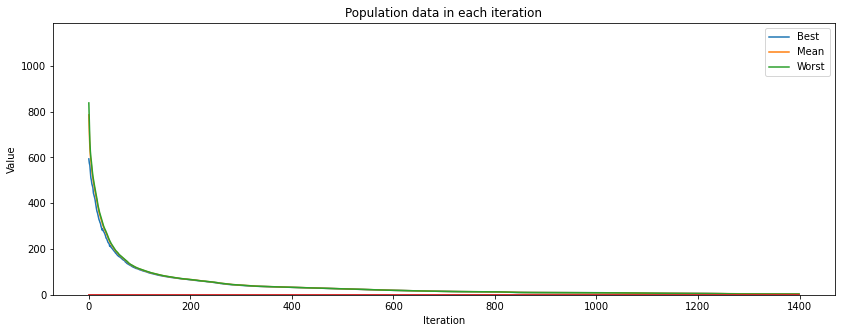

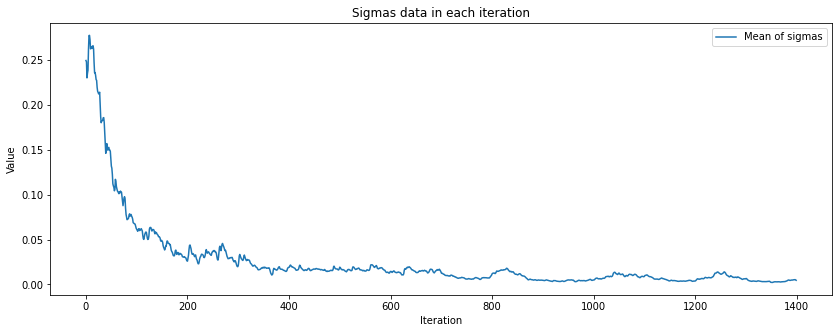

In [10]:
test(SphereFunction, 'roulette', iters = 1400)

#### 

## Rastrigin function
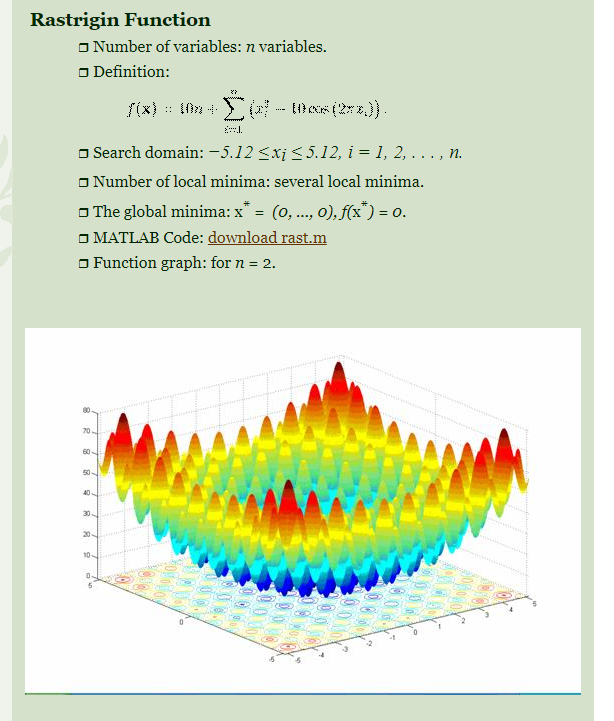
$f(\mathbf {x} )=10n+\sum _{i=1}^{n}\left[x_{i}^{2}-10\cos(2\pi x_{i})\right]$

In [12]:
class RastriginFunction:
    low = -5.12
    high = 5.12
    low_sigma = 0
    high_sigma = 2
    
    def objective_function(ind):
        return 10*len(ind) + np.sum(ind**2 - 10*np.cos(2*np.pi*ind))
        
    def random_population(d, N):
        return np.random.uniform(low = RastriginFunction.low, high = RastriginFunction.high, size = (N, d))
    
    def random_sigmas_population(d, N):
        return np.random.uniform(high = RastriginFunction.high_sigma, size = (N, d))

Mu + Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, sum


Iteration 1. Current min:  85.77737858120759
Iteration 100. Current min:  10.95040274257532
Iteration 200. Current min:  0.001249166071126145
Iteration 300. Current min:  0.001249166071126145
Iteration 400. Current min:  0.001249166071126145
Iteration 500. Current min:  0.001249166071126145
Iteration 600. Current min:  0.001249166071126145
Iteration 700. Current min:  0.001249166071126145
Iteration 800. Current min:  0.001249166071126145
Iteration 900. Current min:  0.001249166071126145
Iteration 1000. Current min:  0.001249166071126145
Iteration 1100. Current min:  0.001249166071126145
Iteration 1200. Current min:  0.001249166071126145
Iteration 1300. Current min:  0.001249166071126145
Iteration 1400. Current min:  0.001249166071126145
Iteration 1500. Current min:  0.001249166071126145



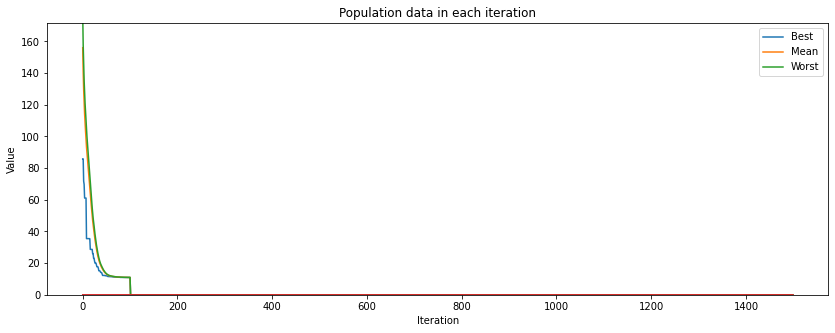

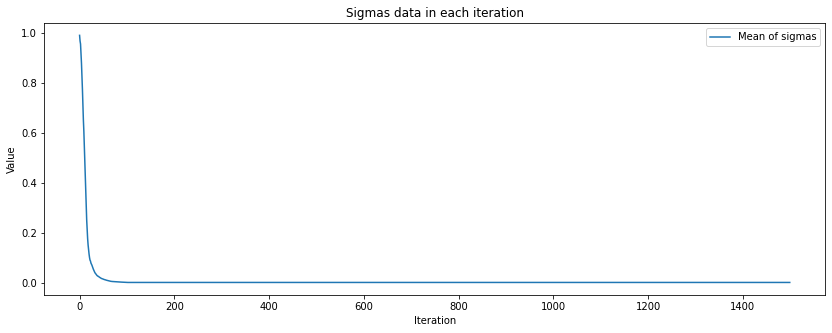

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, sum


Iteration 1. Current min:  692.6438683402694
Iteration 100. Current min:  289.5436594656736
Iteration 200. Current min:  229.08472629941264
Iteration 300. Current min:  218.26572273882914
Iteration 400. Current min:  213.1677861730838
Iteration 500. Current min:  211.5503320859279
Iteration 600. Current min:  209.47920445847922
Iteration 700. Current min:  208.28294158005758
Iteration 800. Current min:  0.0012499540237685383
Iteration 900. Current min:  0.0012499540237685383
Iteration 1000. Current min:  0.0012499540237685383
Iteration 1100. Current min:  0.0012499540237685383
Iteration 1200. Current min:  0.0012499540237685383
Iteration 1300. Current min:  0.0012499540237685383
Iteration 1400. Current min:  0.0012499540237685383
Iteration 1500. Current min:  0.0012499540237685383



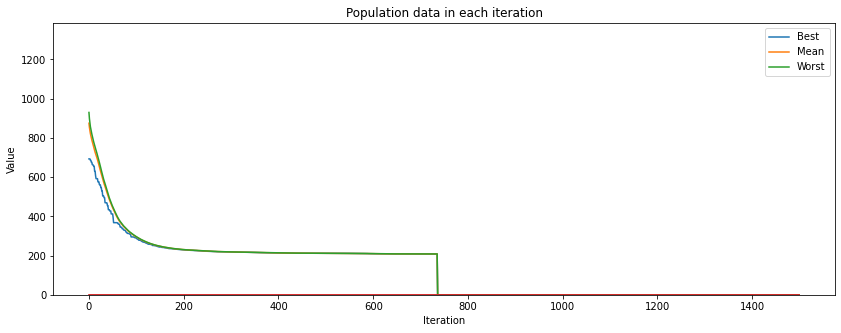

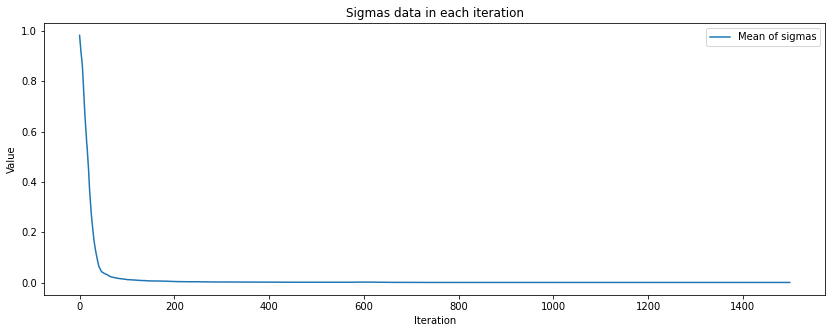

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, sum


Iteration 1. Current min:  1526.3404138936598
Iteration 100. Current min:  1002.6669625767523
Iteration 200. Current min:  838.1552841196934
Iteration 300. Current min:  786.7724111080526
Iteration 400. Current min:  760.8150778584156
Iteration 500. Current min:  744.6446442199052
Iteration 600. Current min:  731.1090147873733
Iteration 700. Current min:  725.6406532474607
Iteration 800. Current min:  719.851911425968
Iteration 900. Current min:  700.3015784042445
Iteration 1000. Current min:  697.2902812310348
Iteration 1100. Current min:  694.8757694841604
Iteration 1200. Current min:  692.9193836811735
Iteration 1300. Current min:  691.8232747893917
Iteration 1400. Current min:  689.1793446170997
Iteration 1500. Current min:  678.8863634875495



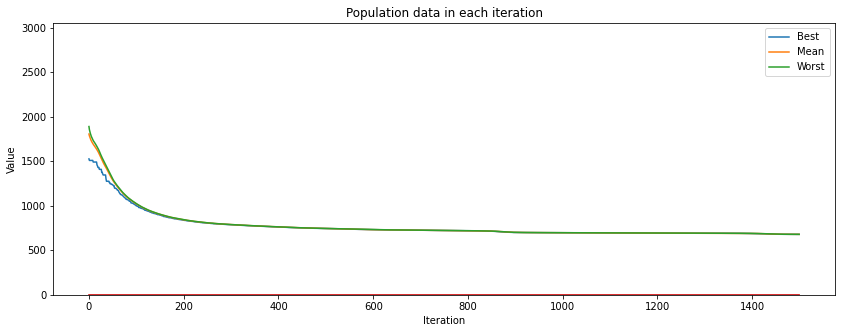

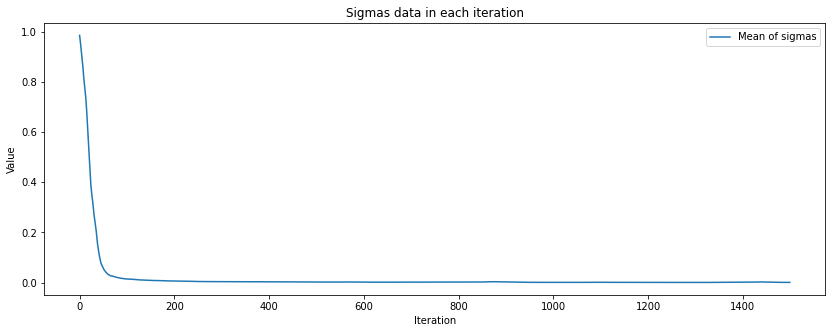

Mu, Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, just_offspring


Iteration 1. Current min:  93.00673956587565
Iteration 100. Current min:  24.882417674173013
Iteration 200. Current min:  22.921659958909927
Iteration 300. Current min:  22.884018106558827
Iteration 400. Current min:  22.88401796515629
Iteration 500. Current min:  22.884017965154953
Iteration 600. Current min:  22.884017965154925
Iteration 700. Current min:  22.884017965154925
Iteration 800. Current min:  22.884017965154925
Iteration 900. Current min:  22.884017965154925
Iteration 1000. Current min:  22.884017965154925
Iteration 1100. Current min:  22.884017965154925
Iteration 1200. Current min:  22.884017965154925
Iteration 1300. Current min:  22.884017965154925
Iteration 1400. Current min:  22.884017965154925
Iteration 1500. Current min:  22.884017965154925



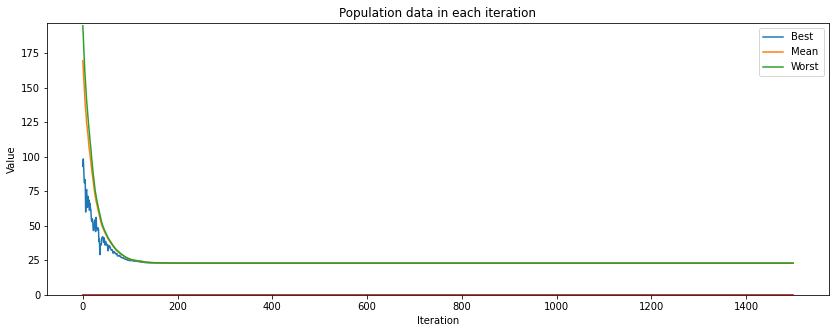

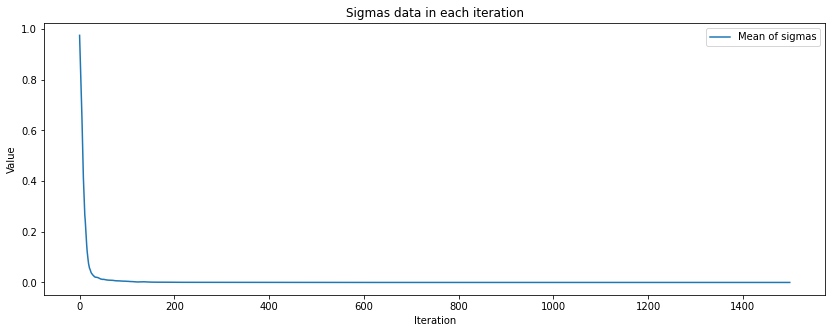

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, just_offspring


Iteration 1. Current min:  713.2331395598137
Iteration 100. Current min:  487.3701642504416
Iteration 200. Current min:  416.5812002504731
Iteration 300. Current min:  394.7782673251448
Iteration 400. Current min:  368.66351986773606
Iteration 500. Current min:  360.6450579366325
Iteration 600. Current min:  357.94295896923165
Iteration 700. Current min:  356.2131808607886
Iteration 800. Current min:  354.9361035336698
Iteration 900. Current min:  352.050565676927
Iteration 1000. Current min:  351.01403566450904
Iteration 1100. Current min:  349.65499735125644
Iteration 1200. Current min:  349.29081296675315
Iteration 1300. Current min:  349.0663446985461
Iteration 1400. Current min:  349.0404422008782
Iteration 1500. Current min:  349.0127667764203



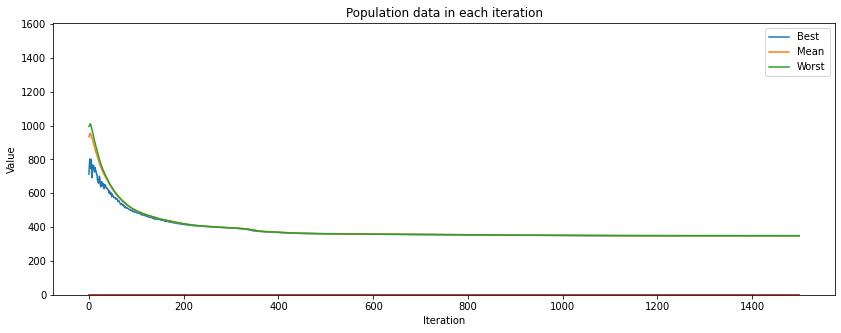

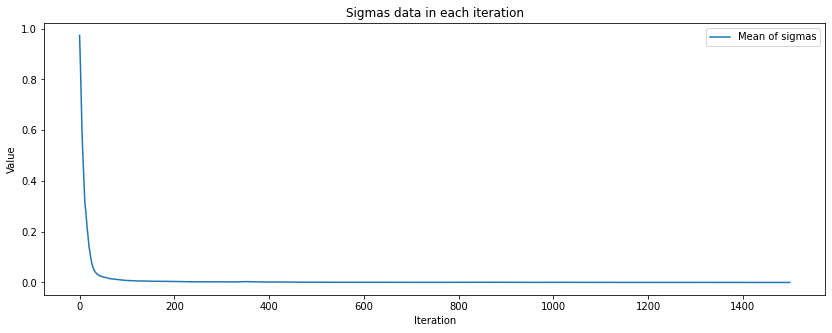

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, just_offspring


Iteration 1. Current min:  1554.191345261899
Iteration 100. Current min:  1370.2585519626634
Iteration 200. Current min:  1185.81008098701
Iteration 300. Current min:  1101.4760546937
Iteration 400. Current min:  1049.5192219057778
Iteration 500. Current min:  1016.5953372537529
Iteration 600. Current min:  992.9700189626046
Iteration 700. Current min:  976.6529912080181
Iteration 800. Current min:  962.600503824897
Iteration 900. Current min:  948.6665113528458
Iteration 1000. Current min:  940.2569728790908
Iteration 1100. Current min:  933.3069349415707
Iteration 1200. Current min:  923.012671179085
Iteration 1300. Current min:  917.0789563338196
Iteration 1400. Current min:  914.0100166566231
Iteration 1500. Current min:  892.5722310375185



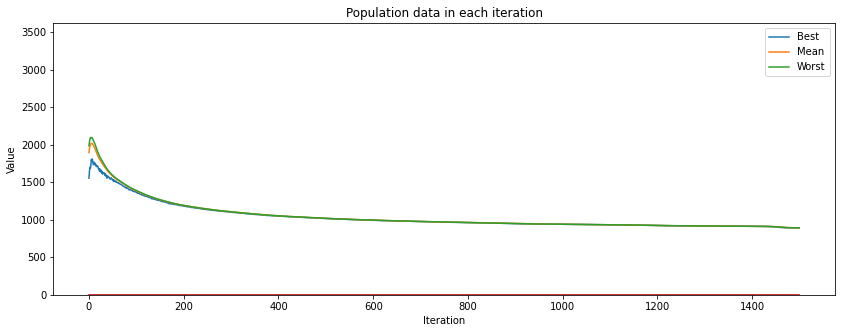

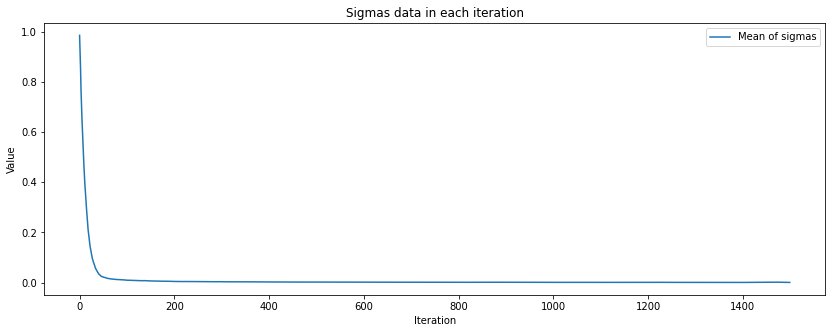

In [13]:
test(RastriginFunction, "reversed_roulette", iters = 1500)

Mu + Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, sum


Iteration 1. Current min:  85.43558708383313
Iteration 100. Current min:  3.9798362291972467
Iteration 200. Current min:  3.979836228373159
Iteration 300. Current min:  3.979836228373159
Iteration 400. Current min:  3.979836228373159
Iteration 500. Current min:  3.979836228373159
Iteration 600. Current min:  3.979836228373159
Iteration 700. Current min:  3.979836228373159
Iteration 800. Current min:  3.979836228373159
Iteration 900. Current min:  3.979836228373159
Iteration 1000. Current min:  3.979836228373159
Iteration 1100. Current min:  3.979836228373159
Iteration 1200. Current min:  3.979836228373159
Iteration 1300. Current min:  3.979836228373159
Iteration 1400. Current min:  3.979836228373159
Iteration 1500. Current min:  3.979836228373159



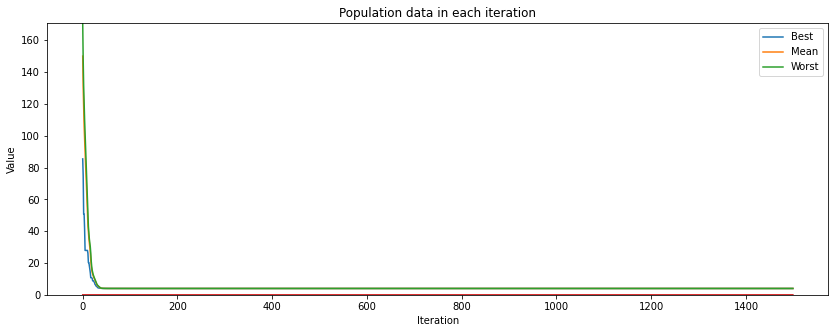

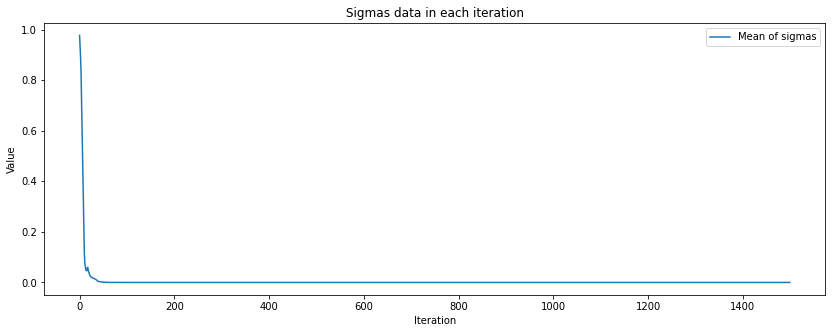

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, sum


Iteration 1. Current min:  697.8730611609973
Iteration 100. Current min:  218.02711011560473
Iteration 200. Current min:  211.5256112557281
Iteration 300. Current min:  209.19421479296557
Iteration 400. Current min:  208.8755140460774
Iteration 500. Current min:  208.07174005958973
Iteration 600. Current min:  204.8824470623864
Iteration 700. Current min:  195.3775004488774
Iteration 800. Current min:  195.34655539616296
Iteration 900. Current min:  195.33232328943137
Iteration 1000. Current min:  195.03263527574256
Iteration 1100. Current min:  195.0151216600023
Iteration 1200. Current min:  195.0135542828708
Iteration 1300. Current min:  195.01323317286835
Iteration 1400. Current min:  195.01219772058346
Iteration 1500. Current min:  195.01150665321165



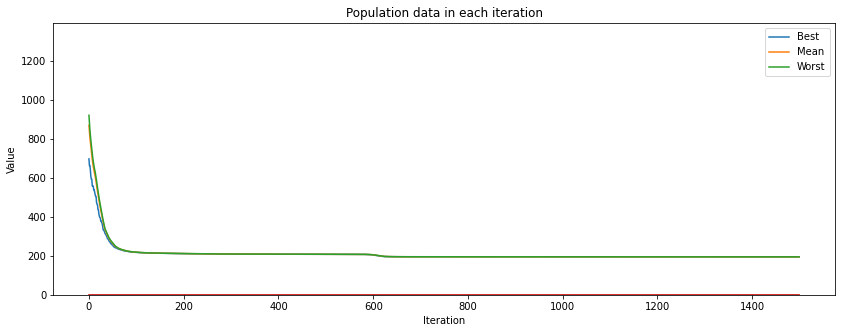

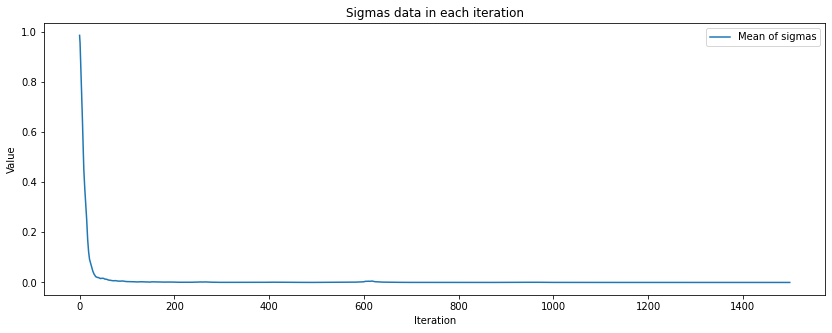

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, sum


Iteration 1. Current min:  1549.1745519037424
Iteration 100. Current min:  717.368453541667
Iteration 200. Current min:  644.8082540331458
Iteration 300. Current min:  608.8621364836758
Iteration 400. Current min:  591.1993182662261
Iteration 500. Current min:  583.4291430284889
Iteration 600. Current min:  581.358339548958
Iteration 700. Current min:  563.8759809819892
Iteration 800. Current min:  559.6976339961236
Iteration 900. Current min:  546.9883994716324
Iteration 1000. Current min:  546.685814046198
Iteration 1100. Current min:  546.5739430225083
Iteration 1200. Current min:  546.4865579850904
Iteration 1300. Current min:  546.2314261258542
Iteration 1400. Current min:  546.1837064286682
Iteration 1500. Current min:  546.1731813171946



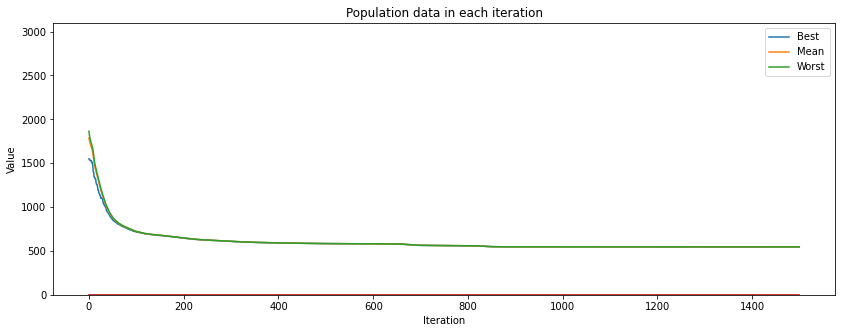

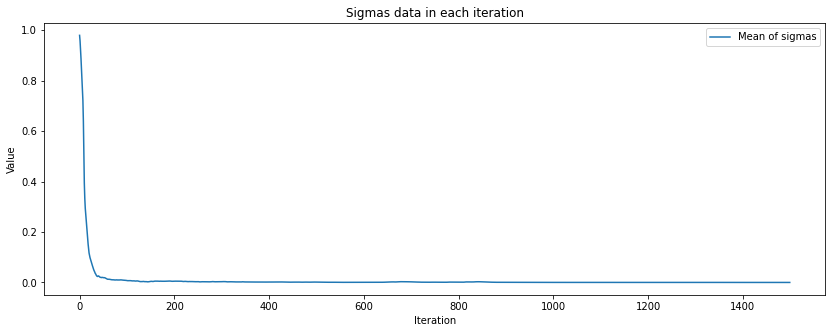

Mu, Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, just_offspring


Iteration 1. Current min:  74.40693368433057
Iteration 100. Current min:  5.969754578421629
Iteration 200. Current min:  5.969754342559753
Iteration 300. Current min:  5.969754342559739
Iteration 400. Current min:  5.969754342559739
Iteration 500. Current min:  5.969754342559739
Iteration 600. Current min:  5.969754342559739
Iteration 700. Current min:  5.969754342559739
Iteration 800. Current min:  5.969754342559739
Iteration 900. Current min:  5.969754342559739
Iteration 1000. Current min:  5.969754342559739
Iteration 1100. Current min:  5.969754342559739
Iteration 1200. Current min:  5.969754342559739
Iteration 1300. Current min:  5.969754342559739
Iteration 1400. Current min:  5.969754342559739
Iteration 1500. Current min:  5.969754342559739



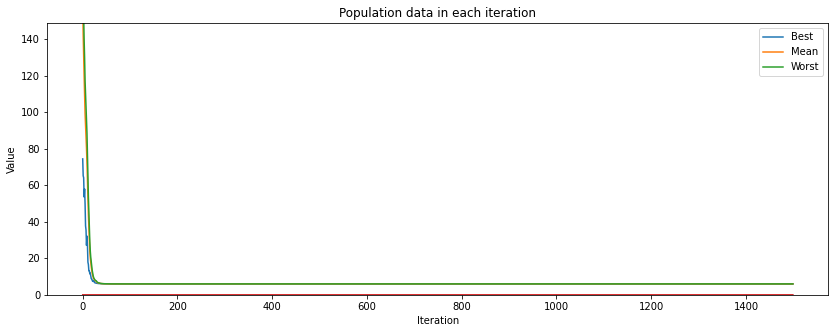

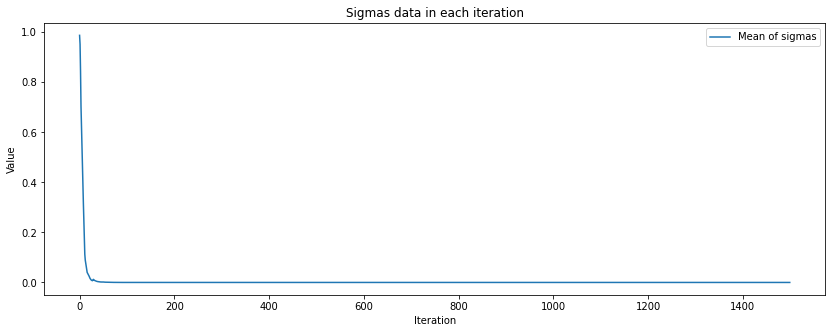

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, just_offspring


Iteration 1. Current min:  705.3188716702757
Iteration 100. Current min:  219.71663977779434
Iteration 200. Current min:  208.5057331186278
Iteration 300. Current min:  206.4876050178858
Iteration 400. Current min:  188.87561546138267
Iteration 500. Current min:  186.2609520367082
Iteration 600. Current min:  186.1878295834399
Iteration 700. Current min:  186.08165906719063
Iteration 800. Current min:  186.07444615598303
Iteration 900. Current min:  186.06626449611355
Iteration 1000. Current min:  186.06212544564778
Iteration 1100. Current min:  186.0618650462905
Iteration 1200. Current min:  186.06174266084844
Iteration 1300. Current min:  186.0598097153133
Iteration 1400. Current min:  186.05766697346132
Iteration 1500. Current min:  186.05660967674692



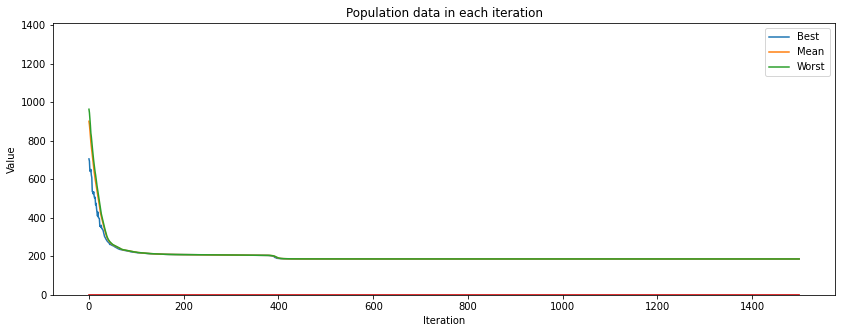

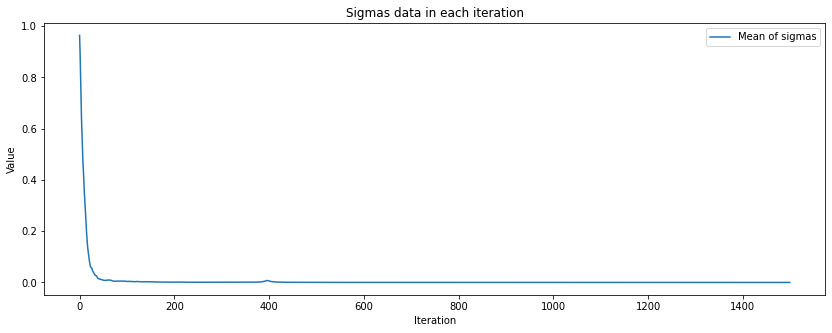

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, just_offspring


Iteration 1. Current min:  1585.6967259824896
Iteration 100. Current min:  670.5886048073419
Iteration 200. Current min:  629.9516739922294
Iteration 300. Current min:  614.9966636312636
Iteration 400. Current min:  596.6622355105737
Iteration 500. Current min:  579.7380171588031
Iteration 600. Current min:  575.1487604857475
Iteration 700. Current min:  566.8375290239467
Iteration 800. Current min:  566.0011162157002
Iteration 900. Current min:  555.6725808015491
Iteration 1000. Current min:  552.6606818386758
Iteration 1100. Current min:  538.3061994110141
Iteration 1200. Current min:  536.1136728554068
Iteration 1300. Current min:  535.9249010595829
Iteration 1400. Current min:  535.2594685996495
Iteration 1500. Current min:  524.4518632671673



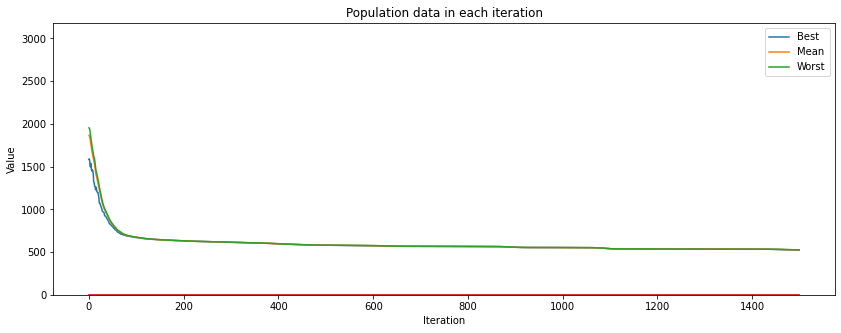

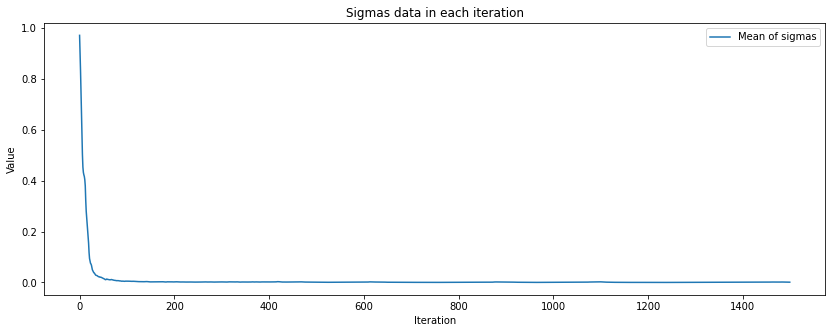

In [14]:
test(RastriginFunction, "roulette", iters = 1500)

Mu + Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, sum


Iteration 1. Current min:  81.60271409732779
Iteration 100. Current min:  1.990444077207755
Iteration 200. Current min:  1.9899181141954898
Iteration 300. Current min:  1.9899181141865796
Iteration 400. Current min:  1.9899181141865796
Iteration 500. Current min:  1.9899181141865796
Iteration 600. Current min:  1.9899181141865796
Iteration 700. Current min:  1.9899181141865796
Iteration 800. Current min:  1.9899181141865796
Iteration 900. Current min:  1.9899181141865796
Iteration 1000. Current min:  1.9899181141865796
Iteration 1100. Current min:  1.9899181141865796
Iteration 1200. Current min:  1.9899181141865796
Iteration 1300. Current min:  1.9899181141865796
Iteration 1400. Current min:  1.9899181141865796
Iteration 1500. Current min:  1.9899181141865796



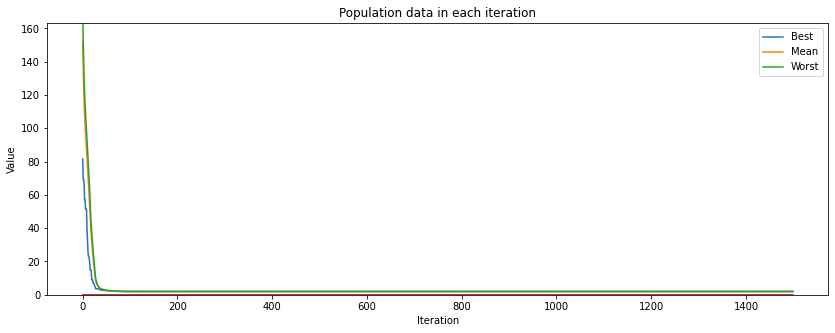

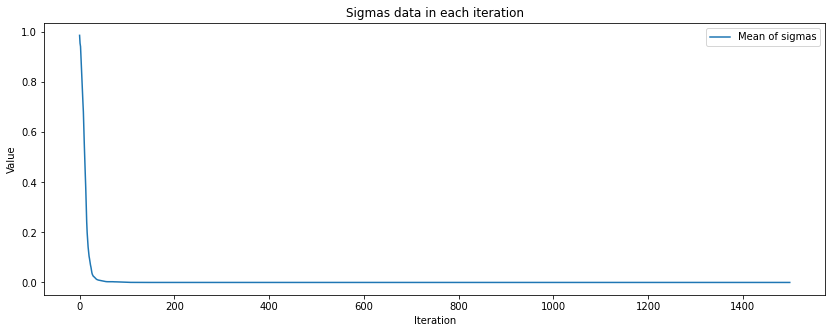

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, sum


Iteration 1. Current min:  698.8642546004638
Iteration 100. Current min:  289.36011326676214
Iteration 200. Current min:  261.9363645807423
Iteration 300. Current min:  245.56853110926627
Iteration 400. Current min:  242.20592135586446
Iteration 500. Current min:  238.96676173599536
Iteration 600. Current min:  225.2306276565235
Iteration 700. Current min:  225.05002760326977
Iteration 800. Current min:  224.9762300692331
Iteration 900. Current min:  224.93287264056556
Iteration 1000. Current min:  224.9013739670711
Iteration 1100. Current min:  224.87271822396895
Iteration 1200. Current min:  224.869042356369
Iteration 1300. Current min:  224.8662253347274
Iteration 1400. Current min:  224.86333159748926
Iteration 1500. Current min:  224.86328028875835



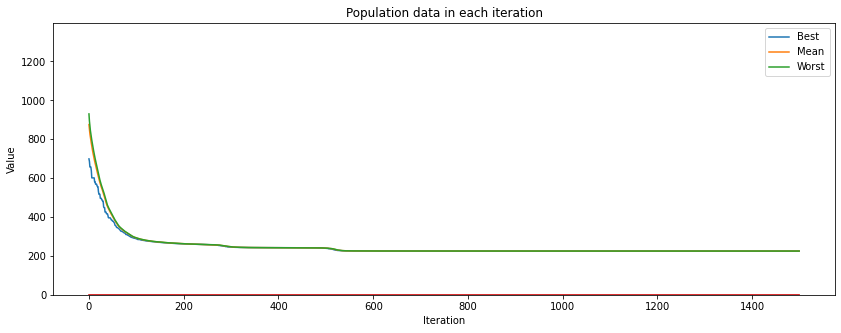

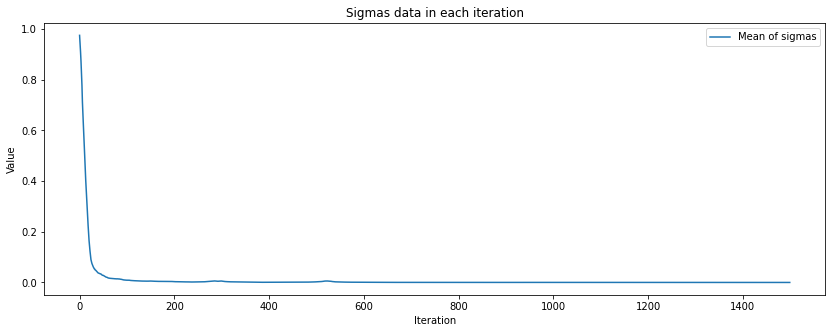

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, sum


Iteration 1. Current min:  1456.242177124555
Iteration 100. Current min:  770.2764178736279
Iteration 200. Current min:  648.9492146010389
Iteration 300. Current min:  622.2103871682436
Iteration 400. Current min:  609.0131573897643
Iteration 500. Current min:  602.5838147281296
Iteration 600. Current min:  598.7917209505861
Iteration 700. Current min:  585.4512436481674
Iteration 800. Current min:  579.3145599375893
Iteration 900. Current min:  569.8548213631984
Iteration 1000. Current min:  567.8229561257403
Iteration 1100. Current min:  567.1025408846189
Iteration 1200. Current min:  566.2410987364526
Iteration 1300. Current min:  563.1388351893743
Iteration 1400. Current min:  562.7838841459752
Iteration 1500. Current min:  562.6505161514762



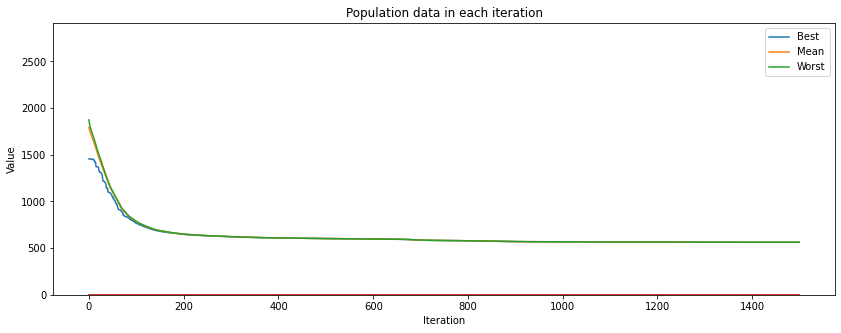

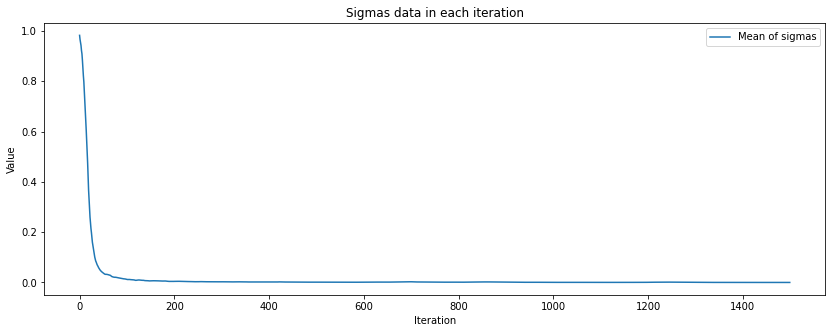

Mu, Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, just_offspring


Iteration 1. Current min:  81.07412494634224
Iteration 100. Current min:  8.9639296238674
Iteration 200. Current min:  8.954627190357726
Iteration 300. Current min:  8.954626476028352
Iteration 400. Current min:  8.954626476020536
Iteration 500. Current min:  8.954626476020536
Iteration 600. Current min:  8.954626476020536
Iteration 700. Current min:  8.954626476020536
Iteration 800. Current min:  8.954626476020536
Iteration 900. Current min:  8.954626476020536
Iteration 1000. Current min:  8.954626476020536
Iteration 1100. Current min:  8.954626476020536
Iteration 1200. Current min:  8.954626476020536
Iteration 1300. Current min:  8.954626476020536
Iteration 1400. Current min:  8.954626476020536
Iteration 1500. Current min:  8.954626476020536



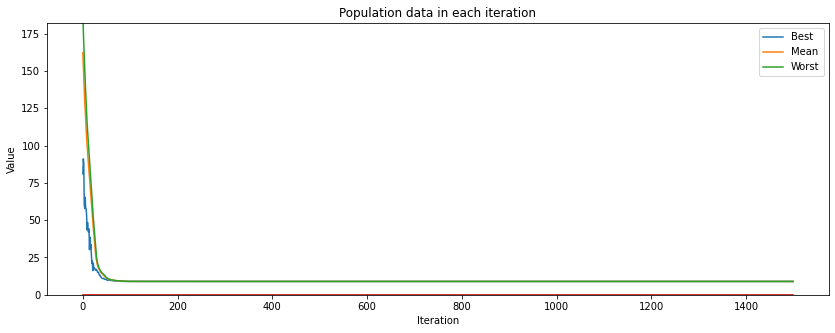

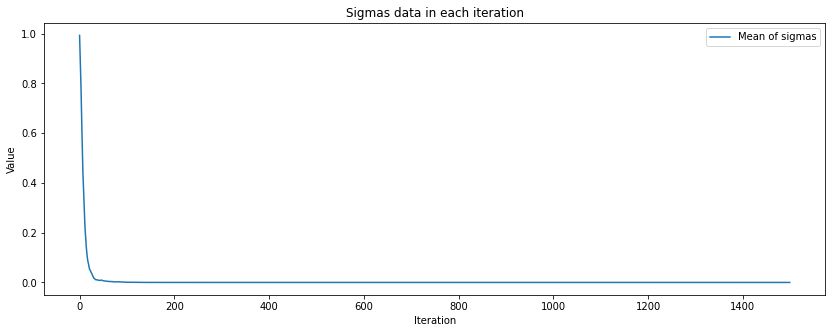

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, just_offspring


Iteration 1. Current min:  728.7754232173293
Iteration 100. Current min:  291.51332026530565
Iteration 200. Current min:  247.9765429155444
Iteration 300. Current min:  236.70535135266897
Iteration 400. Current min:  233.5947645540532
Iteration 500. Current min:  231.61212551479485
Iteration 600. Current min:  226.2507334311507
Iteration 700. Current min:  225.9779277733155
Iteration 800. Current min:  225.1558247034306
Iteration 900. Current min:  224.74094486746753
Iteration 1000. Current min:  224.63955738497822
Iteration 1100. Current min:  224.35006711956436
Iteration 1200. Current min:  224.33164183347446
Iteration 1300. Current min:  224.32388115337073
Iteration 1400. Current min:  224.31822218602542
Iteration 1500. Current min:  224.3119476669558



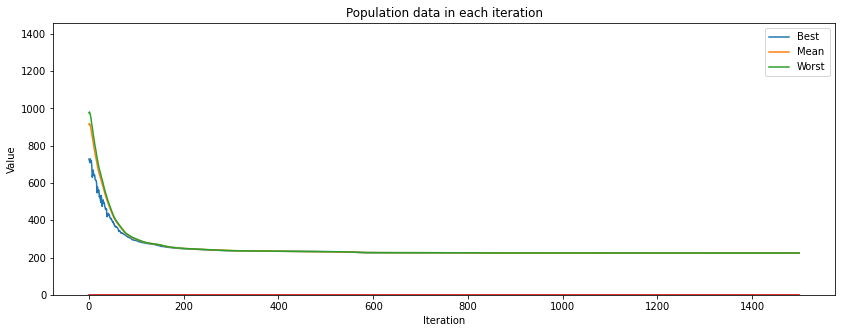

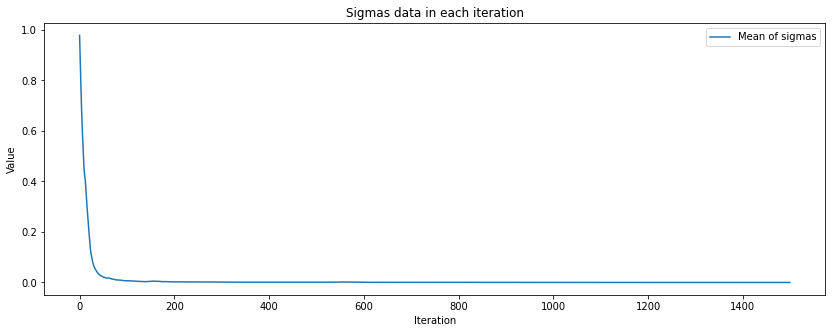

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, just_offspring


Iteration 1. Current min:  1620.2179522275264
Iteration 100. Current min:  1057.3205346542063
Iteration 200. Current min:  919.6700860918784
Iteration 300. Current min:  876.9141197139022
Iteration 400. Current min:  852.2801416393902
Iteration 500. Current min:  838.4076568190393
Iteration 600. Current min:  823.8471193487584
Iteration 700. Current min:  815.7227150165382
Iteration 800. Current min:  797.8347053094286
Iteration 900. Current min:  788.1253516346414
Iteration 1000. Current min:  784.7176252466776
Iteration 1100. Current min:  782.7635507483619
Iteration 1200. Current min:  780.8530956508363
Iteration 1300. Current min:  771.5881108056853
Iteration 1400. Current min:  768.7670651466071
Iteration 1500. Current min:  766.9477633602053



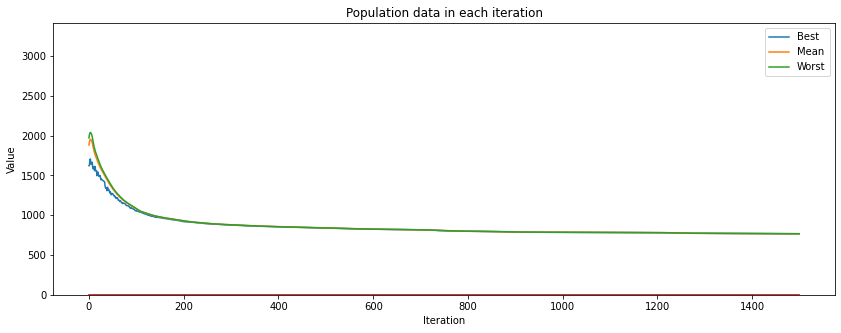

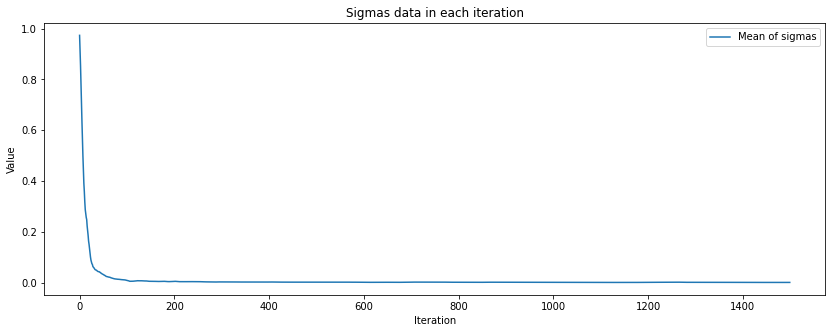

In [15]:
test(RastriginFunction, "random", iters = 1500)

## Zakharov function
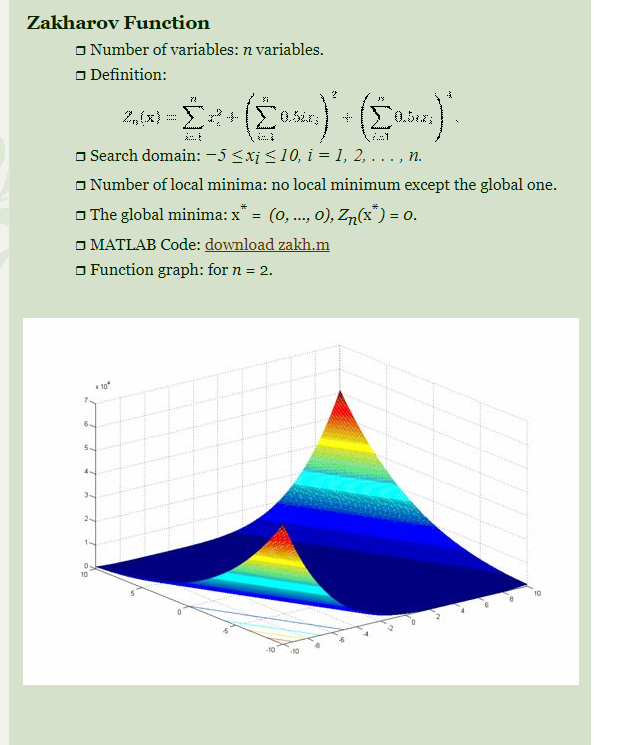
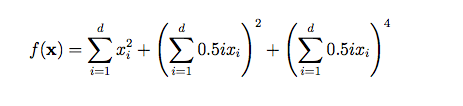

In [34]:
class ZakharovFunction:
    low = -5
    high = 10
    low_sigma = 0
    high_sigma = 2
    
#     def objective_function(ind):
#         return (np.sum(ind**2) + 
#                 np.sum(np.array([0.5 * i * ind[i] for i in range(len(ind))])) ** 2 + 
#                 np.sum(np.array([0.5 * i * ind[i] for i in range(len(ind))])) ** 4)
    
    def objective_function(ind):
        i_x = ind * range(1, len(ind)+1)
        return np.sum(ind**2) + np.sum(0.5 * i_x) ** 2 + np.sum(0.5 * i_x) ** 4
    
    def random_population(d, N):
        return np.random.uniform(low = ZakharovFunction.low, high = ZakharovFunction.high, size = (N, d))
    
    def random_sigmas_population(d, N):
        return np.random.uniform(high = ZakharovFunction.high_sigma, size = (N, d))

Mu + Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, sum


Iteration 1. Current min:  53.51050203513842
Iteration 200. Current min:  0.0009662717221542863
Iteration 400. Current min:  0.0009662717221542863
Iteration 600. Current min:  0.0009662717221542863
Iteration 800. Current min:  0.0009662717221542863
Iteration 1000. Current min:  0.0009662717221542863
Iteration 1200. Current min:  0.0009662717221542863
Iteration 1400. Current min:  0.0009662717221542863
Iteration 1500. Current min:  0.0009662717221542863



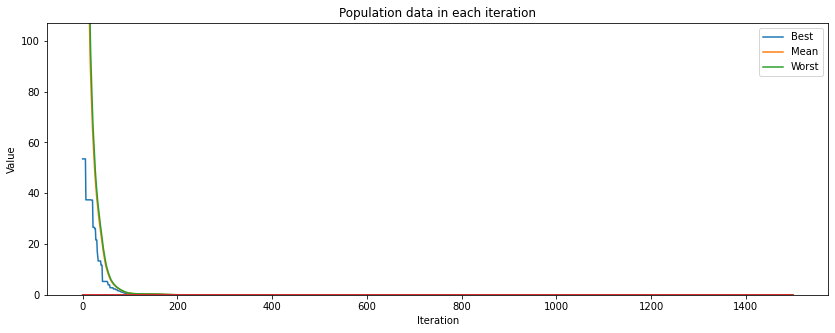

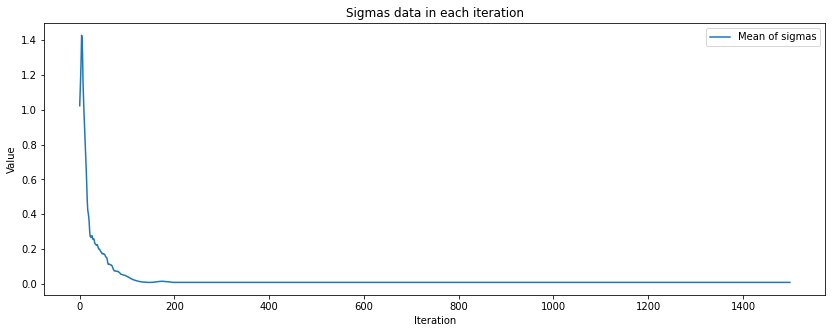

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, sum


Iteration 1. Current min:  69292.21452831548
Iteration 200. Current min:  627.4299318930312
Iteration 400. Current min:  458.77251595039235
Iteration 600. Current min:  343.7540103299502
Iteration 800. Current min:  268.65943369978646
Iteration 1000. Current min:  208.04342278835475
Iteration 1200. Current min:  143.17225098594147
Iteration 1400. Current min:  103.75327838761014
Iteration 1500. Current min:  90.0089315001609



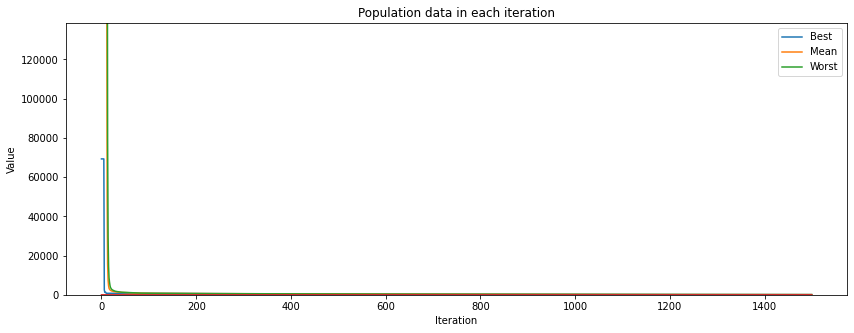

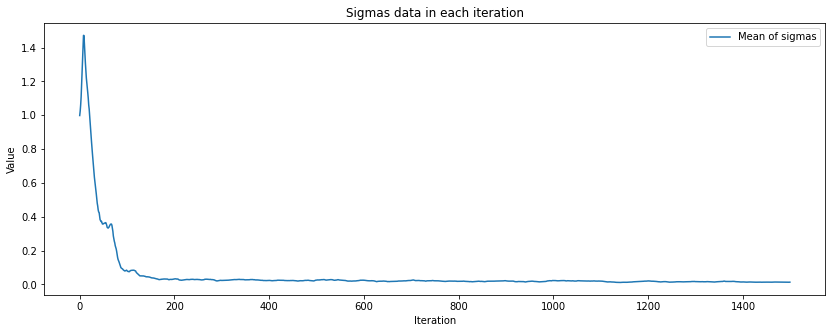

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, sum


Iteration 1. Current min:  57628411835593.22
Iteration 200. Current min:  2336.4239341697394
Iteration 400. Current min:  2336.4239341697394
Iteration 600. Current min:  2336.4239341697394
Iteration 800. Current min:  2247.6538082944235
Iteration 1000. Current min:  2113.7079024301474
Iteration 1200. Current min:  1945.215242852881
Iteration 1400. Current min:  1815.888417655326
Iteration 1500. Current min:  1760.115827849178



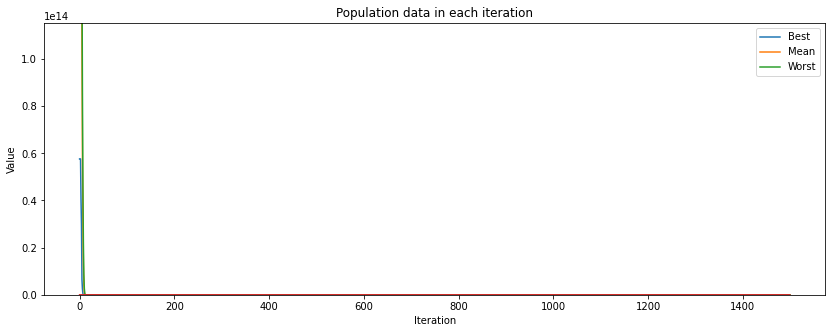

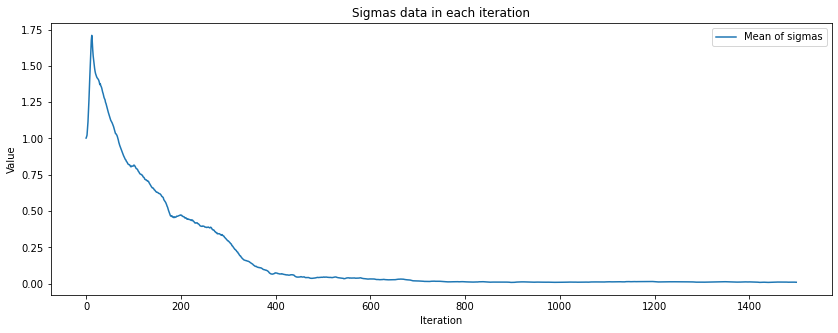

Mu, Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, just_offspring


Iteration 1. Current min:  39792.729220566645
Iteration 200. Current min:  42.33395344731517
Iteration 400. Current min:  6.677892729687473
Iteration 600. Current min:  0.8395865929623676
Iteration 800. Current min:  0.013854985011075299
Iteration 1000. Current min:  1.9749638204646964e-05
Iteration 1200. Current min:  2.0604084265480726e-08
Iteration 1400. Current min:  5.989883513509772e-11
Iteration 1500. Current min:  1.199477509068776e-12



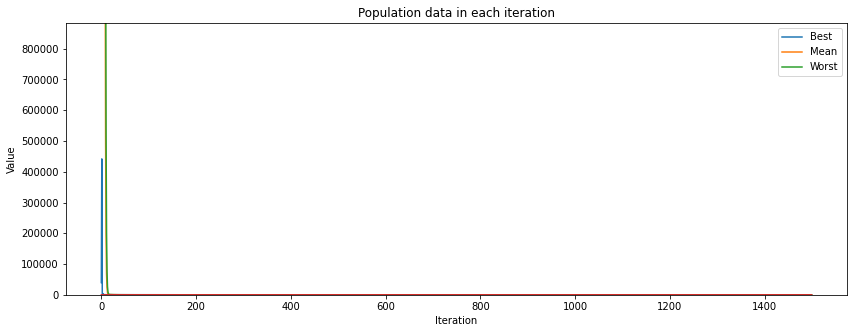

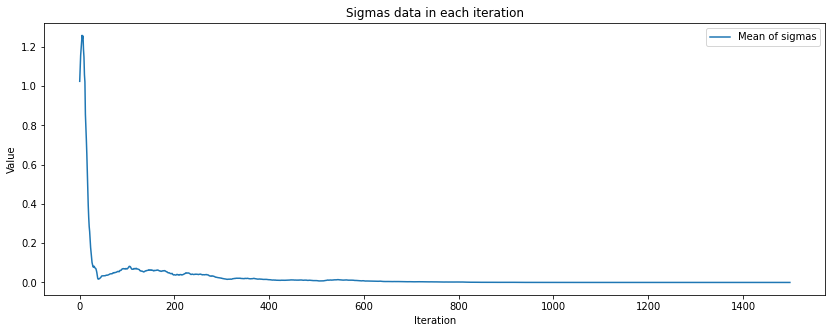

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, just_offspring


Iteration 1. Current min:  363491652180.39215
Iteration 200. Current min:  3032.82227932647
Iteration 400. Current min:  2587.1112324054366
Iteration 600. Current min:  2341.0953015922223
Iteration 800. Current min:  2150.959981172569
Iteration 1000. Current min:  2017.6955607795041
Iteration 1200. Current min:  1944.1152322809228
Iteration 1400. Current min:  1838.5095032893264
Iteration 1500. Current min:  1777.3649594568753



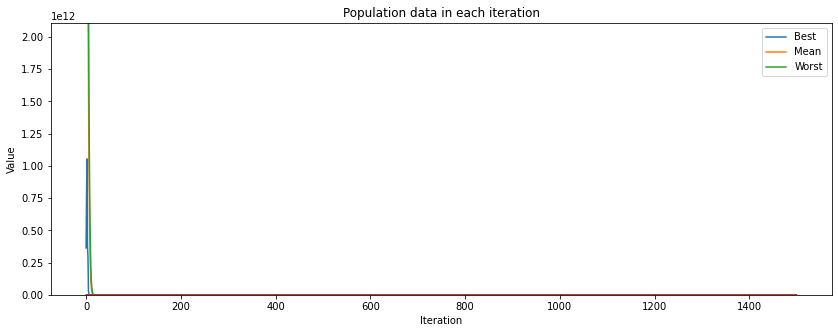

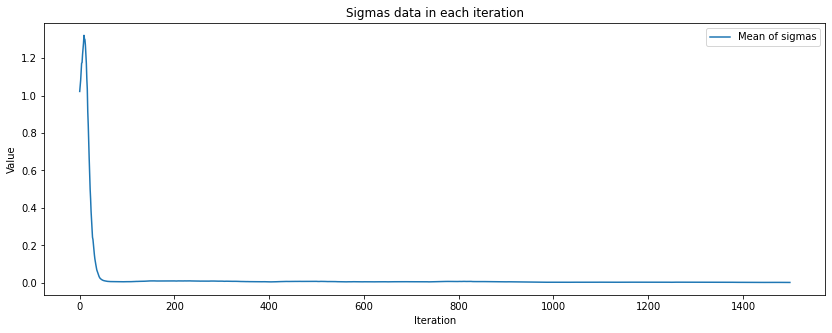

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, just_offspring


Iteration 1. Current min:  100428709311698.66
Iteration 200. Current min:  6065.269300321192
Iteration 400. Current min:  5886.065918078025
Iteration 600. Current min:  5624.334585189186
Iteration 800. Current min:  5388.45471512479
Iteration 1000. Current min:  5192.349198768318
Iteration 1200. Current min:  5038.466945634071
Iteration 1400. Current min:  4910.671098713333
Iteration 1500. Current min:  4861.129647012993



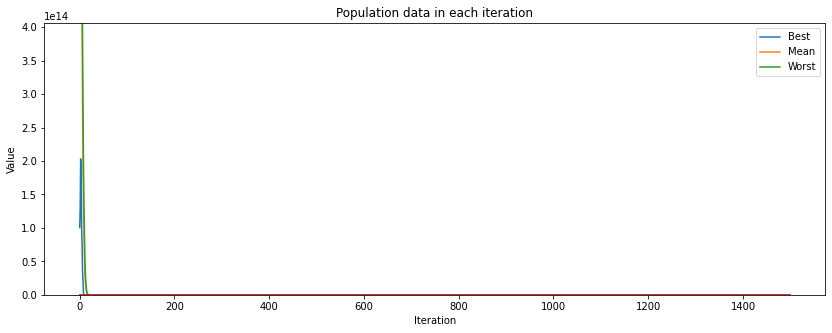

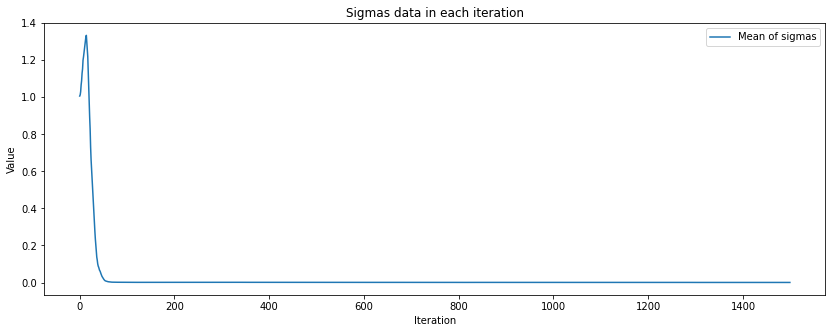

In [42]:
test(ZakharovFunction, "reversed_roulette", iters = 1500)

Mu + Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, sum


Iteration 1. Current min:  60.14124051340441
Iteration 200. Current min:  7.953746994415682e-10
Iteration 400. Current min:  7.889337130868841e-26
Iteration 600. Current min:  3.0620712227819357e-42
Iteration 800. Current min:  5.274381965783446e-61
Iteration 1000. Current min:  1.4107218569012933e-78
Iteration 1200. Current min:  2.255839283480808e-93
Iteration 1400. Current min:  4.62665135933685e-111
Iteration 1500. Current min:  2.2046723198360423e-119



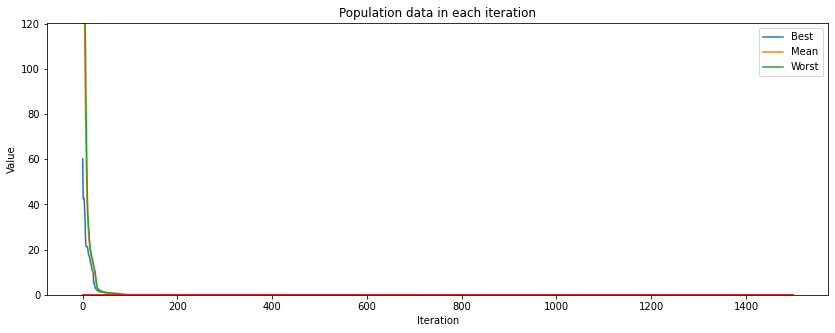

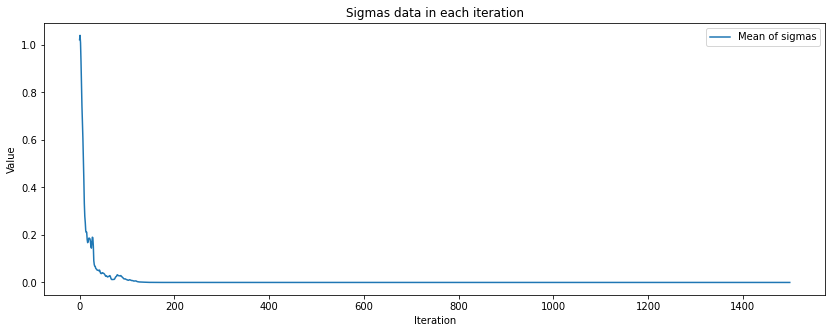

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, sum


Iteration 1. Current min:  698.0984247835675
Iteration 200. Current min:  145.13200010486395
Iteration 400. Current min:  71.29324191144333
Iteration 600. Current min:  52.51935733485039
Iteration 800. Current min:  39.39557571717104
Iteration 1000. Current min:  32.771988841341724
Iteration 1200. Current min:  17.944656336361756
Iteration 1400. Current min:  17.138924462996027
Iteration 1500. Current min:  5.9348471334405515



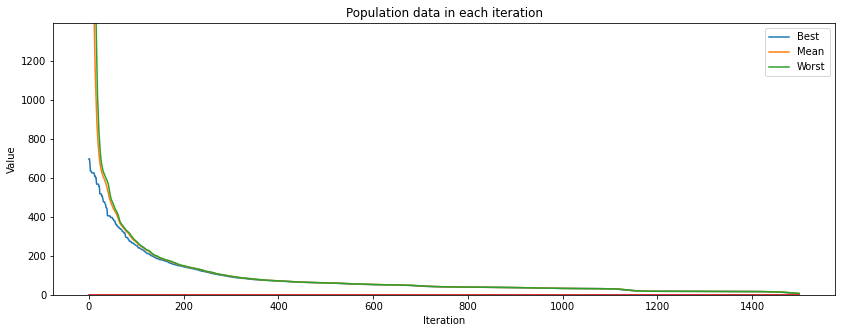

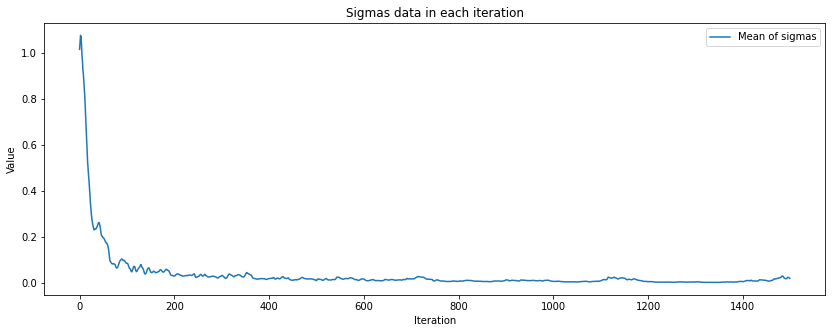

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, sum


Iteration 1. Current min:  27491823463364.453
Iteration 200. Current min:  1678.6969959606627
Iteration 400. Current min:  1173.3797155750958
Iteration 600. Current min:  950.5058007101601
Iteration 800. Current min:  792.1708356811665
Iteration 1000. Current min:  679.2498335549659
Iteration 1200. Current min:  609.4727764646221
Iteration 1400. Current min:  552.528227975709
Iteration 1500. Current min:  530.6918177152049



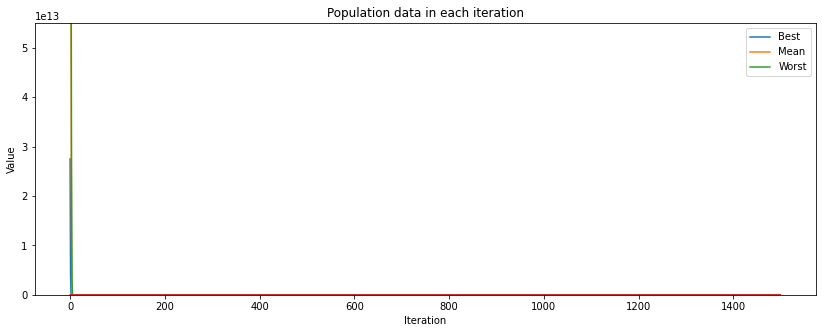

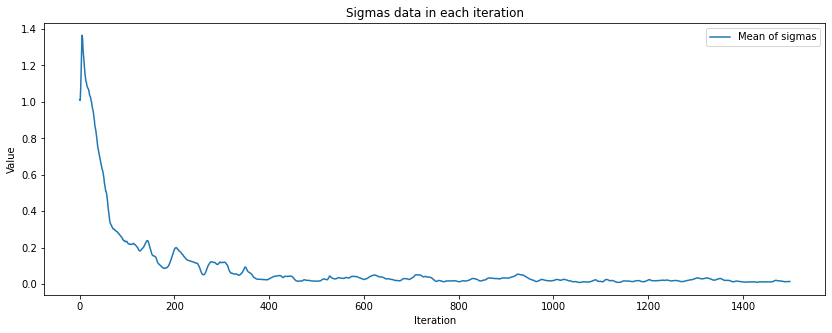

Mu, Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, just_offspring


Iteration 1. Current min:  118.88648918677355
Iteration 200. Current min:  7.318828403071933e-11
Iteration 400. Current min:  8.330636779437953e-24
Iteration 600. Current min:  4.051362750236327e-39
Iteration 800. Current min:  1.2212276782355704e-52
Iteration 1000. Current min:  6.9359098201143724e-65
Iteration 1200. Current min:  2.75171140176583e-80
Iteration 1400. Current min:  1.8396377471224387e-94
Iteration 1500. Current min:  4.932170952429672e-102



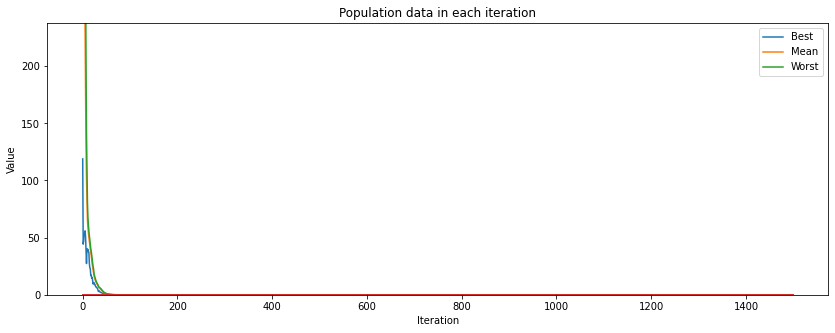

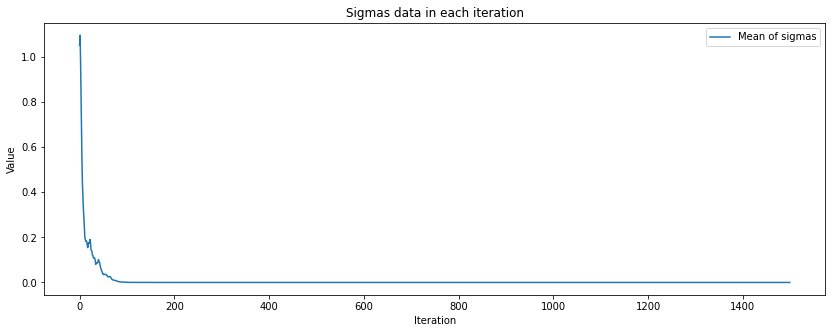

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, just_offspring


Iteration 1. Current min:  179324781.17694065
Iteration 200. Current min:  423.0066795118169
Iteration 400. Current min:  308.71811689717026
Iteration 600. Current min:  223.4845092473306
Iteration 800. Current min:  167.74967048985474
Iteration 1000. Current min:  148.50503448292253
Iteration 1200. Current min:  83.87130589098554
Iteration 1400. Current min:  65.23740570293806
Iteration 1500. Current min:  38.687199664534



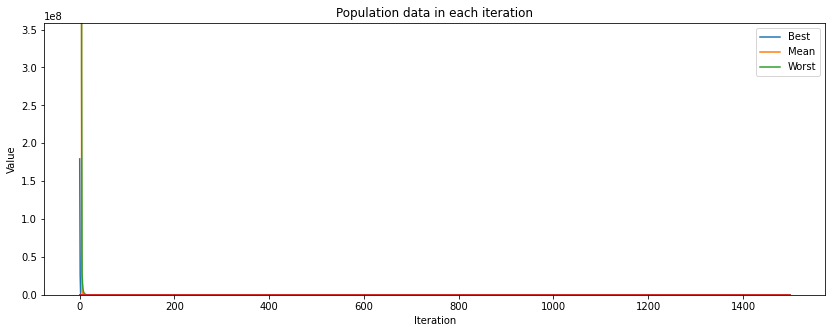

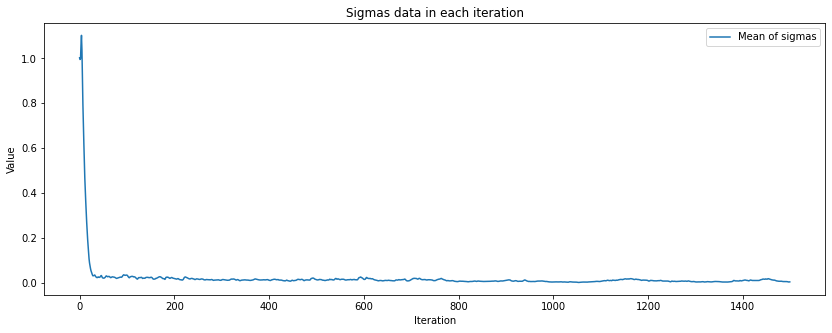

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, just_offspring


Iteration 1. Current min:  12551679408460.627
Iteration 200. Current min:  2512.6332695320402
Iteration 400. Current min:  2056.6625451697723
Iteration 600. Current min:  1825.339028842594
Iteration 800. Current min:  1649.2978920297417
Iteration 1000. Current min:  1527.840282954593
Iteration 1200. Current min:  1348.642437794606
Iteration 1400. Current min:  1230.156189107406
Iteration 1500. Current min:  1194.5393822179742



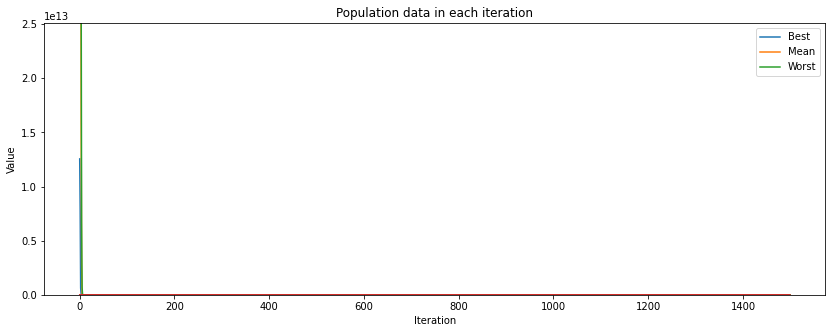

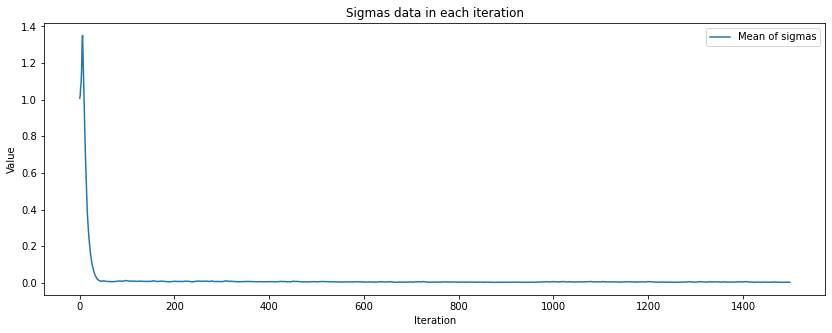

In [43]:
test(ZakharovFunction, "roulette", iters = 1500)

Mu + Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, sum


Iteration 1. Current min:  54.68805325300462
Iteration 200. Current min:  0.0011457316294098473
Iteration 400. Current min:  1.2501240453750116e-09
Iteration 600. Current min:  1.3516127105392484e-18
Iteration 800. Current min:  5.768763859787264e-25
Iteration 1000. Current min:  4.5825850717283313e-35
Iteration 1200. Current min:  2.0464245447772302e-43
Iteration 1400. Current min:  6.495201361914745e-51
Iteration 1500. Current min:  9.376044354767014e-56



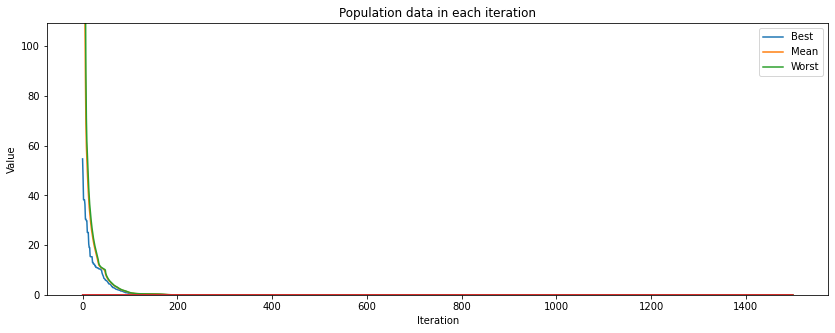

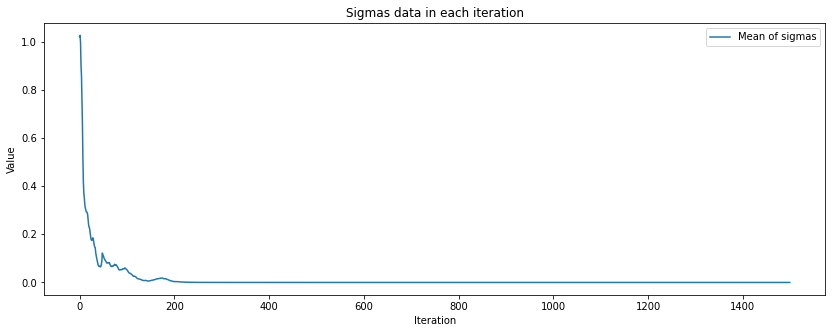

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, sum


Iteration 1. Current min:  29768327.949846417
Iteration 200. Current min:  425.90793267668744
Iteration 400. Current min:  276.90823498174797
Iteration 600. Current min:  222.4834507304085
Iteration 800. Current min:  180.2117452034331
Iteration 1000. Current min:  144.1381579355634
Iteration 1200. Current min:  130.48064298362956
Iteration 1400. Current min:  114.86863164259614
Iteration 1500. Current min:  104.6520098813166



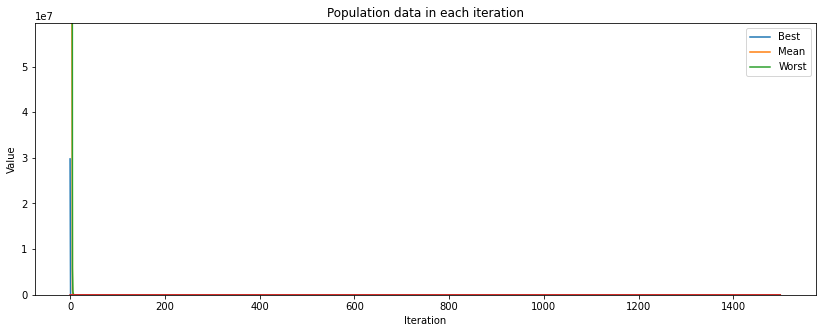

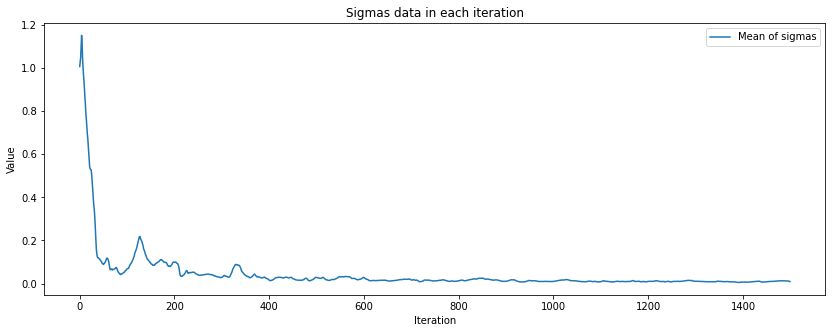

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, sum


Iteration 1. Current min:  4301203645498.3423
Iteration 200. Current min:  2493.528455515457
Iteration 400. Current min:  2185.398979956187
Iteration 600. Current min:  1934.992831391731
Iteration 800. Current min:  1747.9381849264623
Iteration 1000. Current min:  1598.3003127799714
Iteration 1200. Current min:  1503.6683672825063
Iteration 1400. Current min:  1404.1570444463496
Iteration 1500. Current min:  1369.9421408561168



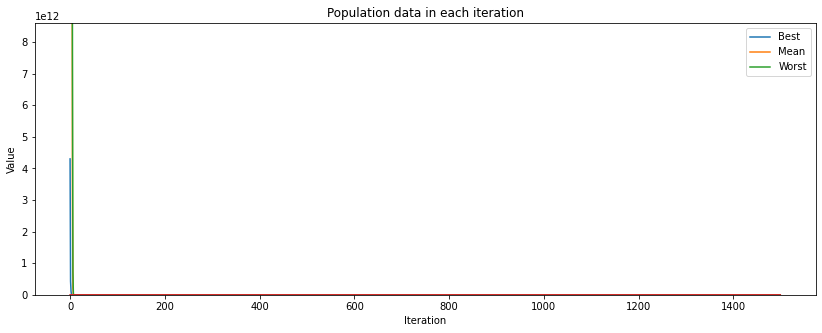

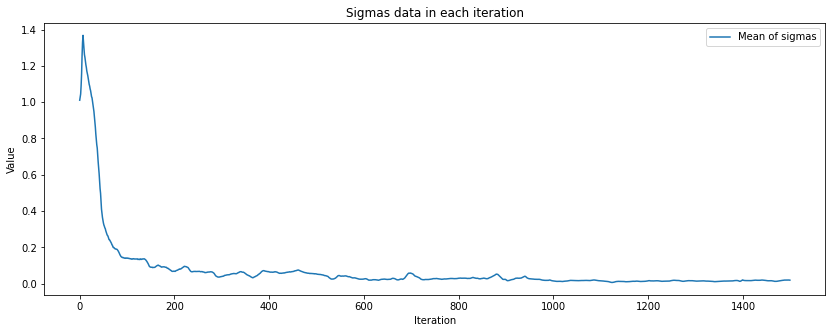

Mu, Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, just_offspring


Iteration 1. Current min:  100.87373282477043
Iteration 200. Current min:  0.004589739802782683
Iteration 400. Current min:  1.6341139684297254e-08
Iteration 600. Current min:  2.63423305535053e-12
Iteration 800. Current min:  6.033224033851292e-17
Iteration 1000. Current min:  6.653936648052686e-20
Iteration 1200. Current min:  3.8911322863460273e-25
Iteration 1400. Current min:  5.975708534527154e-29
Iteration 1500. Current min:  1.1500734766086544e-31



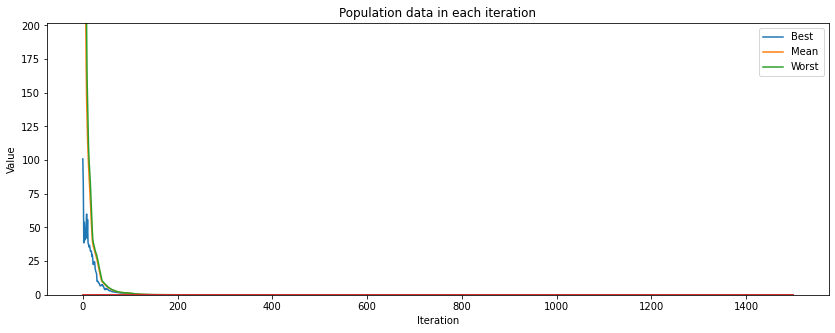

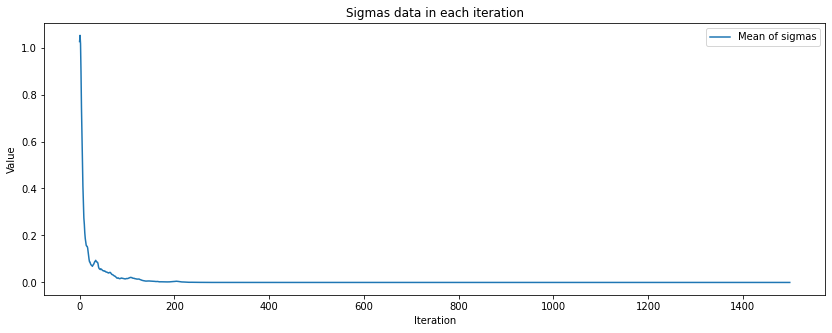

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, just_offspring


Iteration 1. Current min:  415139.40021979663
Iteration 200. Current min:  725.6069977021128
Iteration 400. Current min:  629.3522988802772
Iteration 600. Current min:  550.2447503664323
Iteration 800. Current min:  503.9005286903805
Iteration 1000. Current min:  430.51185306944984
Iteration 1200. Current min:  392.82772095646027
Iteration 1400. Current min:  379.5703238861424
Iteration 1500. Current min:  372.4128140572698



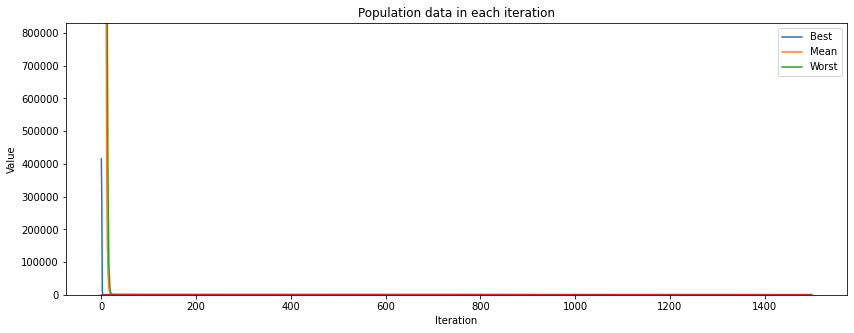

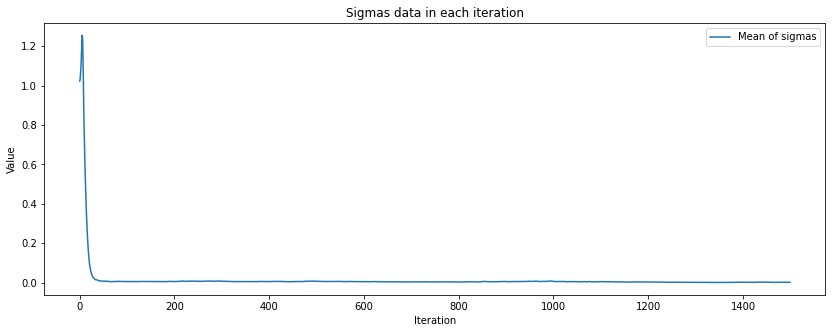

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, just_offspring


Iteration 1. Current min:  39139581856701.836
Iteration 200. Current min:  2493.7906446704374
Iteration 400. Current min:  2408.2347652478843
Iteration 600. Current min:  2324.5960590613486
Iteration 800. Current min:  2240.886304124612
Iteration 1000. Current min:  2154.9547229940963
Iteration 1200. Current min:  2079.69624477155
Iteration 1400. Current min:  1988.0508536227596
Iteration 1500. Current min:  1949.1060725983552



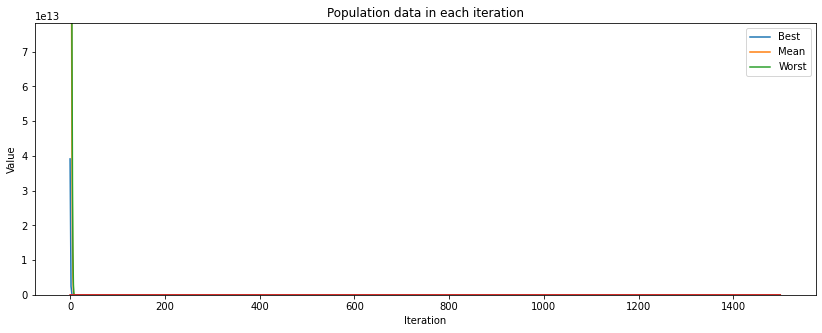

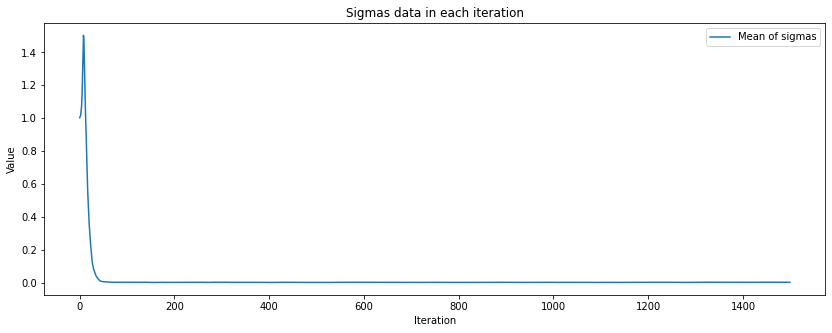

In [44]:
test(ZakharovFunction, "random", iters = 1500)

## Griewank Function
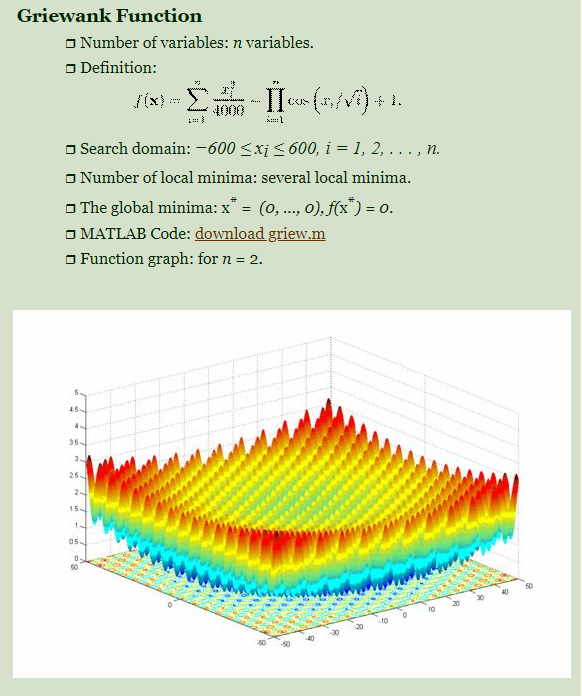
$1+{\frac  {1}{4000}}\sum _{{i=1}}^{n}x_{i}^{2}-\prod _{{i=1}}^{n}\cos \left({\frac  {x_{i}}{{\sqrt  {i}}}}\right)$

In [38]:
class GriewankFunction:
    low = -600
    high = 600
    low_sigma = 0
    high_sigma = 100
    
    def objective_function(ind):
        return (1 + 1/4000 + 
                np.sum(ind**2) -
                np.prod(np.cos(np.array([ind[i]/(i+1) for i in range(len(ind))]))))
        
    def random_population(d, N):
        return np.random.uniform(low = GriewankFunction.low, high = GriewankFunction.high, size = (N, d))
    
    def random_sigmas_population(d, N):
        return np.random.uniform(high = GriewankFunction.high_sigma, size = (N, d))

Mu + Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, sum


Iteration 1. Current min:  185715.5686717759
Iteration 200. Current min:  0.0004902165146044914
Iteration 400. Current min:  0.0004902165146044914
Iteration 600. Current min:  0.0004902165146044914
Iteration 800. Current min:  0.0004902165146044914
Iteration 1000. Current min:  0.0004902165146044914
Iteration 1200. Current min:  0.0004902165146044914
Iteration 1400. Current min:  0.0004902165146044914
Iteration 1500. Current min:  0.0004902165146044914



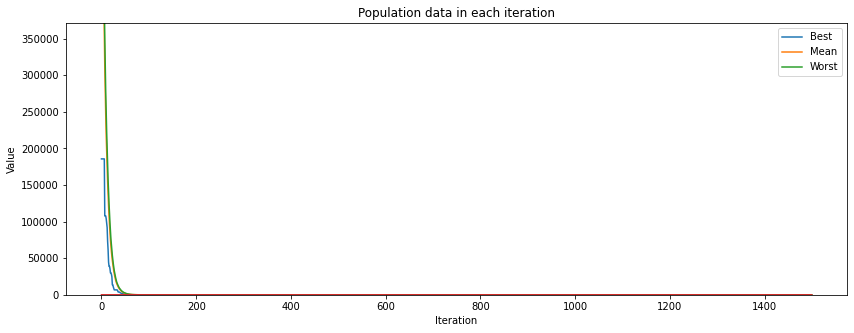

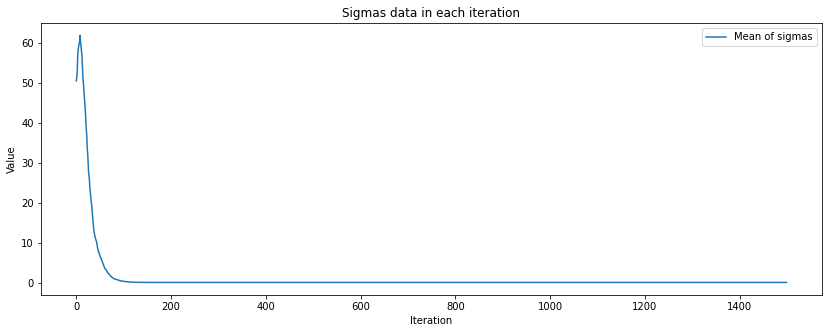

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, sum


Iteration 1. Current min:  3725292.858051485
Iteration 200. Current min:  86047.74242801353
Iteration 400. Current min:  5525.018838392926
Iteration 600. Current min:  399.891263390845
Iteration 800. Current min:  21.839144915755604
Iteration 1000. Current min:  1.1498613549508088
Iteration 1200. Current min:  0.0011940078719682588
Iteration 1400. Current min:  0.0011940078719682588
Iteration 1500. Current min:  0.0011940078719682588



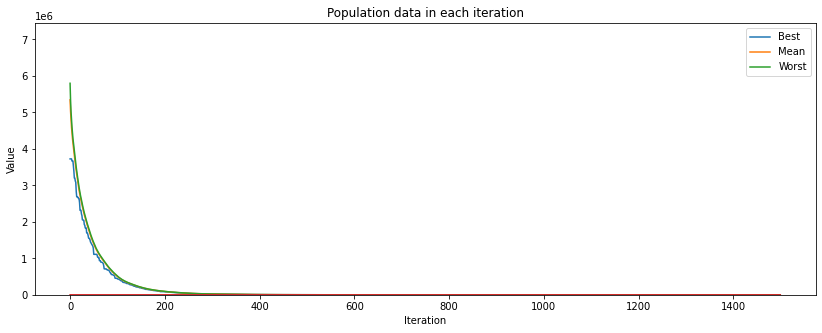

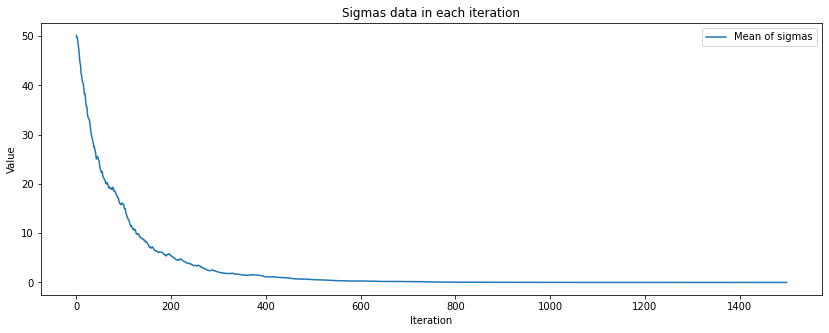

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, sum


Iteration 1. Current min:  8813131.8577842
Iteration 200. Current min:  1360986.2418104997
Iteration 400. Current min:  524912.8522822212
Iteration 600. Current min:  206363.99404376888
Iteration 800. Current min:  97276.71930122413
Iteration 1000. Current min:  43434.27733895467
Iteration 1200. Current min:  28840.426745970606
Iteration 1400. Current min:  15741.129024472079
Iteration 1500. Current min:  12383.014010495564



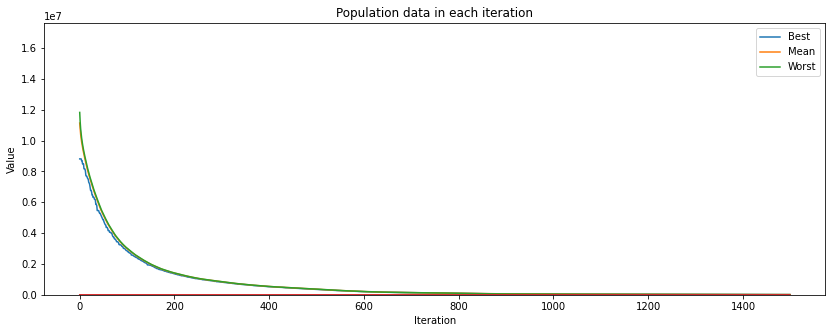

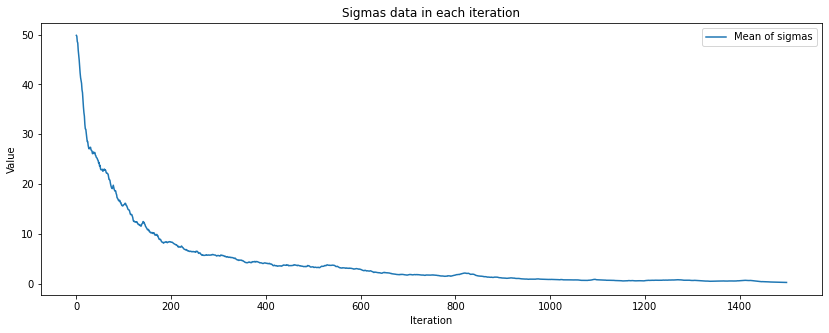

Mu, Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, just_offspring


Iteration 1. Current min:  366187.4213923097
Iteration 200. Current min:  22.069447747430186
Iteration 400. Current min:  0.0006588827363838146
Iteration 600. Current min:  0.0002500000046247175
Iteration 800. Current min:  0.0002500000000000835
Iteration 1000. Current min:  0.0002500000000000835
Iteration 1200. Current min:  0.0002500000000000835
Iteration 1400. Current min:  0.0002500000000000835
Iteration 1500. Current min:  0.0002500000000000835



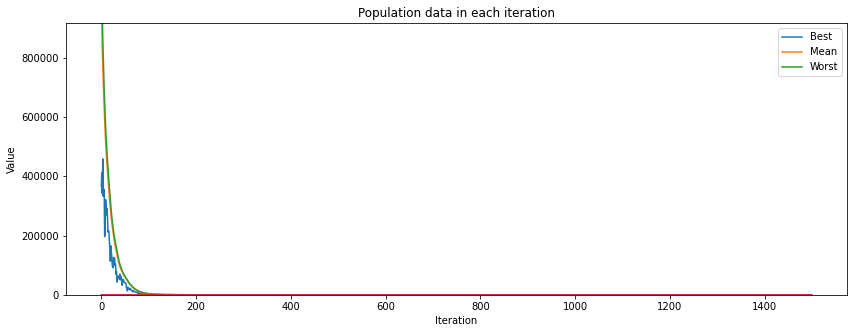

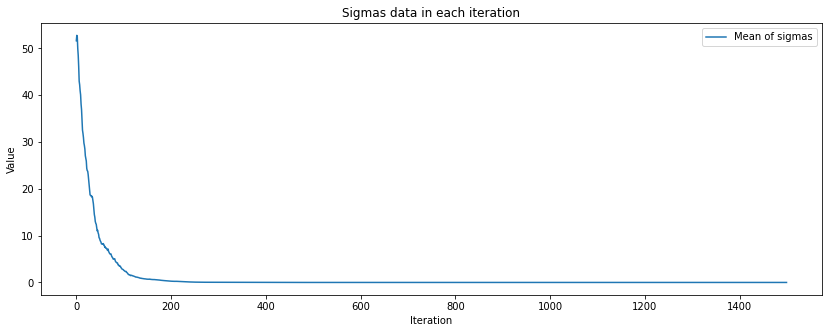

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, just_offspring


Iteration 1. Current min:  4239323.942331082
Iteration 200. Current min:  842493.3582221582
Iteration 400. Current min:  288291.9110674085
Iteration 600. Current min:  134565.5838936214
Iteration 800. Current min:  86561.37010526391
Iteration 1000. Current min:  25805.619133097105
Iteration 1200. Current min:  20305.993710816474
Iteration 1400. Current min:  18768.85152123153
Iteration 1500. Current min:  14814.192191159153



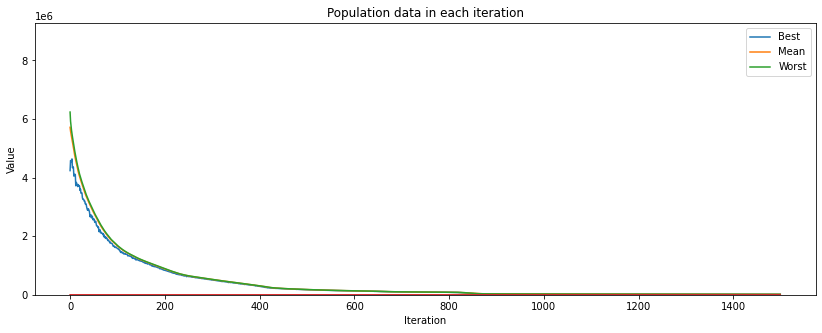

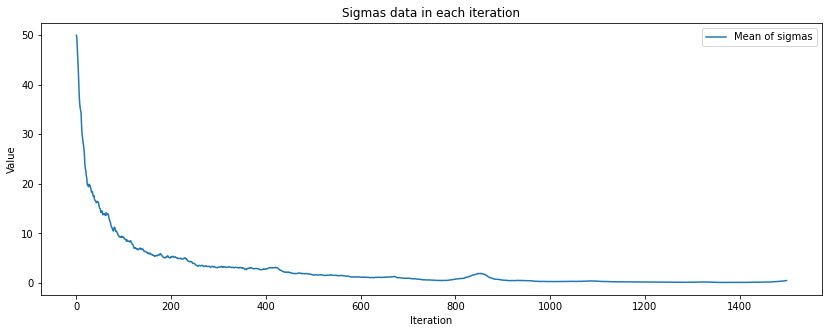

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, just_offspring


Iteration 1. Current min:  9359534.254575964
Iteration 200. Current min:  3727373.0558580854
Iteration 400. Current min:  2133344.208758035
Iteration 600. Current min:  1590744.107523064
Iteration 800. Current min:  1226408.1908098413
Iteration 1000. Current min:  1109036.846698095
Iteration 1200. Current min:  927284.4541748003
Iteration 1400. Current min:  815449.9616443402
Iteration 1500. Current min:  803198.7764614786



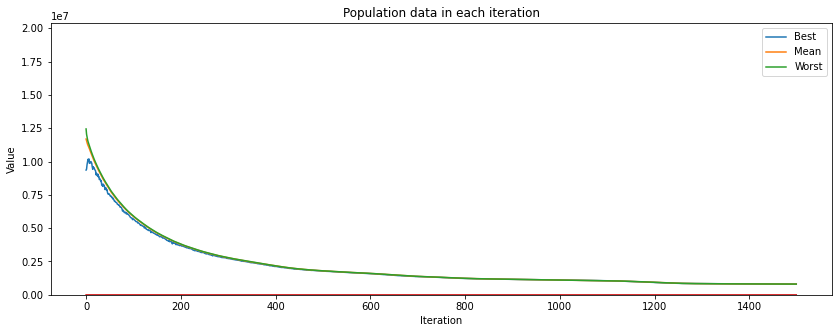

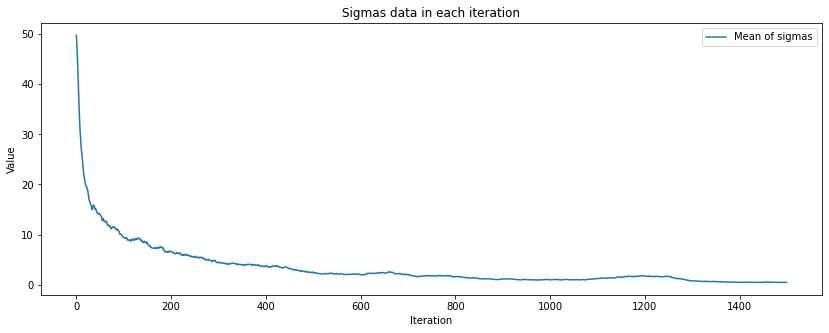

In [39]:
test(GriewankFunction, 'reversed_roulette', 1500)

Mu + Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, sum


Iteration 1. Current min:  265200.669930911
Iteration 200. Current min:  0.0002500000000000835
Iteration 400. Current min:  0.0002500000000000835
Iteration 600. Current min:  0.0002500000000000835
Iteration 800. Current min:  0.0002500000000000835
Iteration 1000. Current min:  0.0002500000000000835
Iteration 1200. Current min:  0.0002500000000000835
Iteration 1400. Current min:  0.0002500000000000835
Iteration 1500. Current min:  0.0002500000000000835



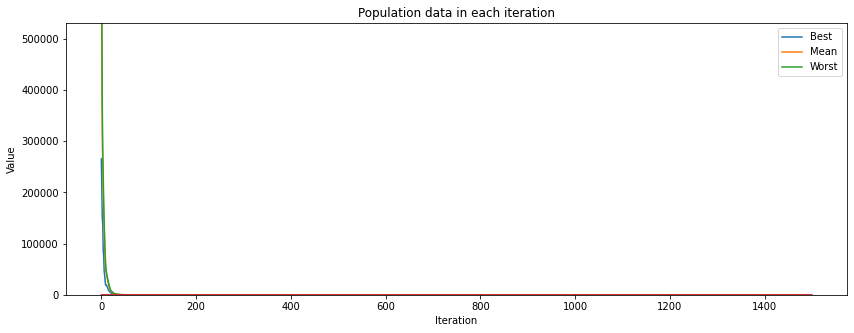

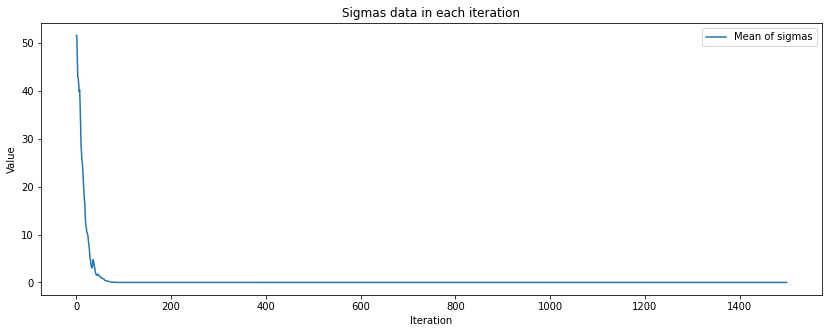

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, sum


Iteration 1. Current min:  3698064.937502814
Iteration 200. Current min:  401619.0332792746
Iteration 400. Current min:  18180.305508494406
Iteration 600. Current min:  14246.689373351053
Iteration 800. Current min:  14068.616550149678
Iteration 1000. Current min:  13903.476367590969
Iteration 1200. Current min:  2902.700714457592
Iteration 1400. Current min:  2825.5170262379393
Iteration 1500. Current min:  2820.455756074728



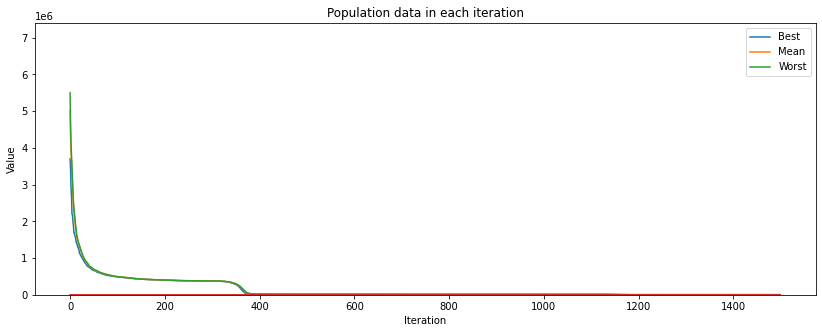

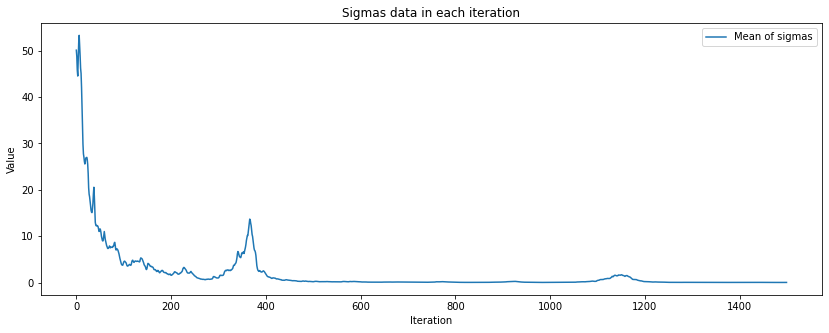

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, sum


Iteration 1. Current min:  8687172.257518332
Iteration 200. Current min:  798469.1794224484
Iteration 400. Current min:  391415.9400433279
Iteration 600. Current min:  245523.33815632784
Iteration 800. Current min:  157613.5950598828
Iteration 1000. Current min:  73721.40499294107
Iteration 1200. Current min:  13340.424458326685
Iteration 1400. Current min:  6182.625691485451
Iteration 1500. Current min:  5376.807977452074



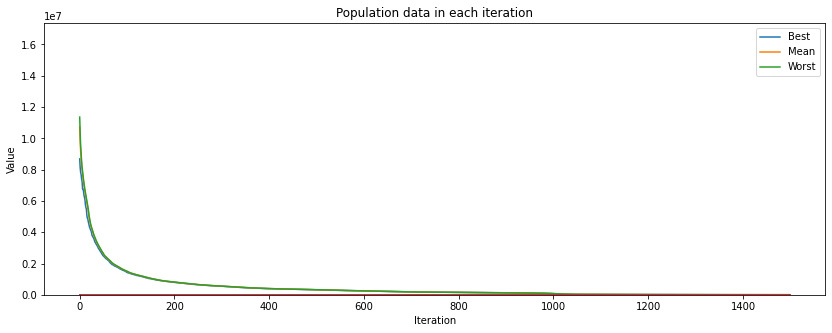

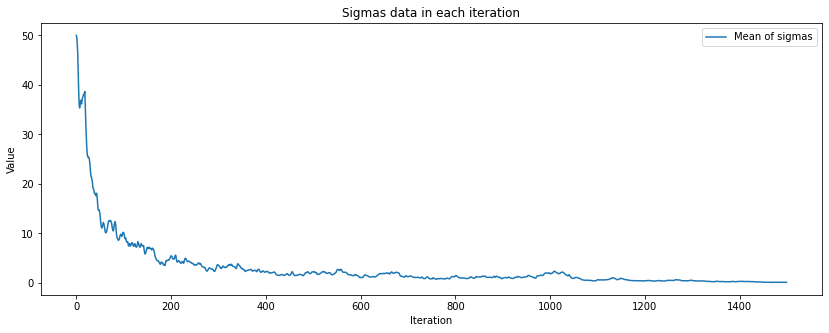

Mu, Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, just_offspring


Iteration 1. Current min:  298014.01632847113
Iteration 200. Current min:  0.0002500000000793534
Iteration 400. Current min:  0.0002500000000000835
Iteration 600. Current min:  0.0002500000000000835
Iteration 800. Current min:  0.0002500000000000835
Iteration 1000. Current min:  0.0002500000000000835
Iteration 1200. Current min:  0.0002500000000000835
Iteration 1400. Current min:  0.0002500000000000835
Iteration 1500. Current min:  0.0002500000000000835



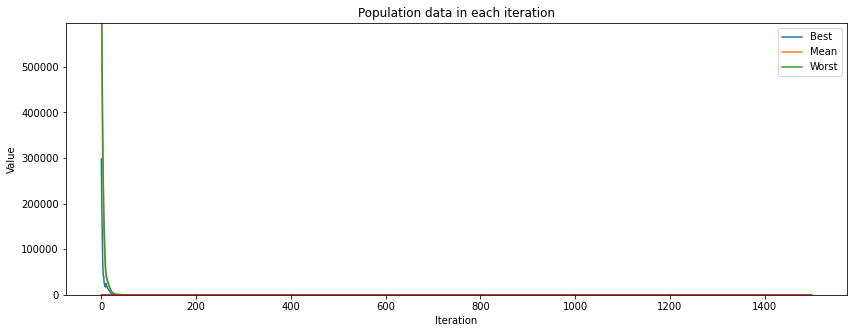

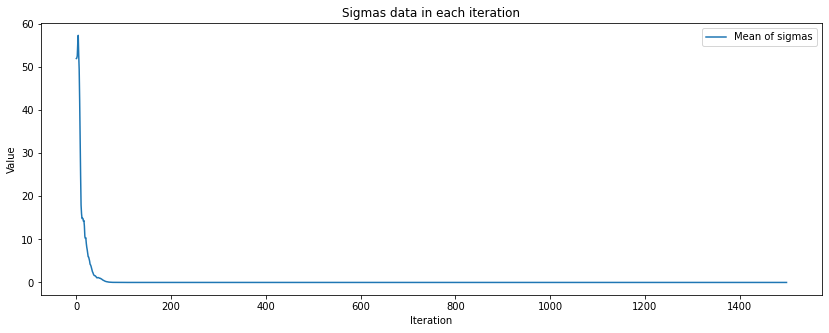

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, just_offspring


Iteration 1. Current min:  3723082.508600768
Iteration 200. Current min:  173779.728474894
Iteration 400. Current min:  38666.62872766416
Iteration 600. Current min:  7491.701813799812
Iteration 800. Current min:  84.07480826826595
Iteration 1000. Current min:  4.86236267320103
Iteration 1200. Current min:  0.16324638791129065
Iteration 1400. Current min:  0.0507338421592064
Iteration 1500. Current min:  0.049414756834269435



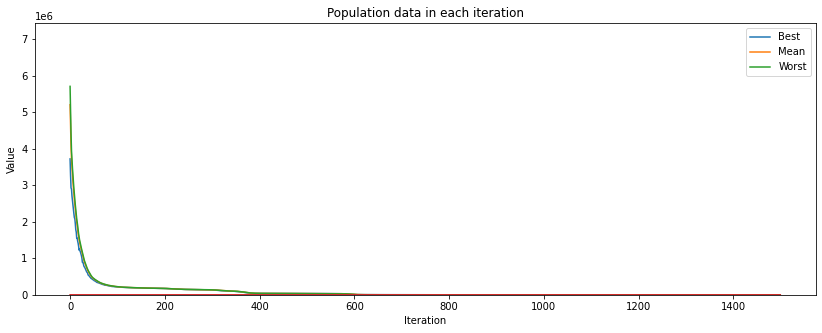

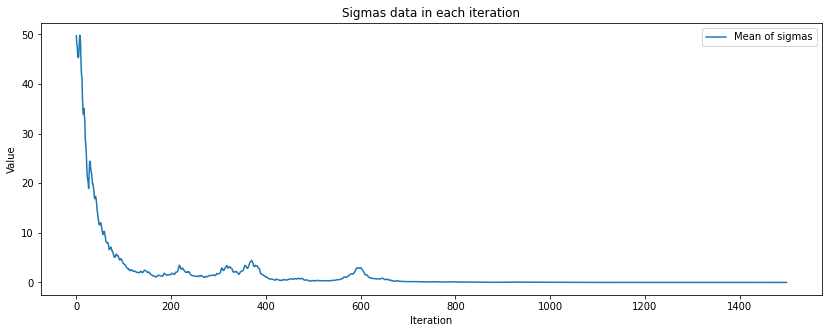

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, just_offspring


Iteration 1. Current min:  8682157.540546127
Iteration 200. Current min:  1407184.7627260203
Iteration 400. Current min:  979849.7557364313
Iteration 600. Current min:  693265.2816338132
Iteration 800. Current min:  612714.3261597645
Iteration 1000. Current min:  386557.47822143836
Iteration 1200. Current min:  344680.700214725
Iteration 1400. Current min:  288111.06439060764
Iteration 1500. Current min:  286550.6396141423



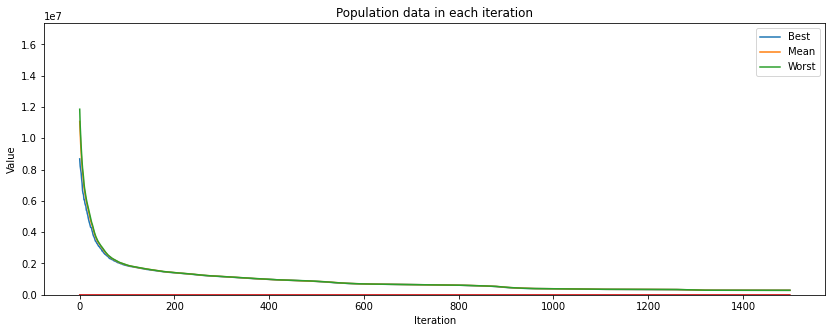

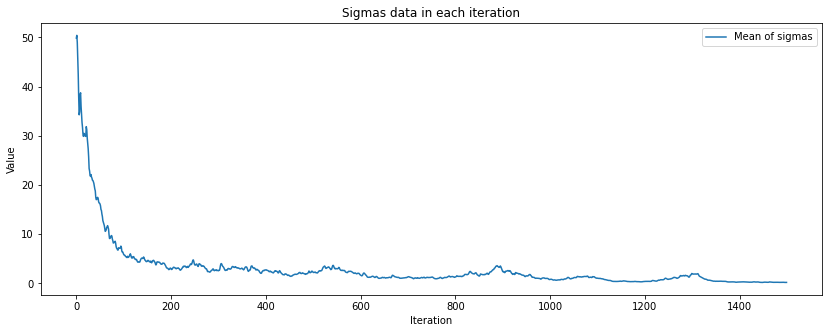

In [40]:
test(GriewankFunction, 'roulette', 1500)

Mu + Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, sum


Iteration 1. Current min:  242232.73955669973
Iteration 200. Current min:  0.000250007078446135
Iteration 400. Current min:  0.0002500000000000835
Iteration 600. Current min:  0.0002500000000000835
Iteration 800. Current min:  0.0002500000000000835
Iteration 1000. Current min:  0.0002500000000000835
Iteration 1200. Current min:  0.0002500000000000835
Iteration 1400. Current min:  0.0002500000000000835
Iteration 1500. Current min:  0.0002500000000000835



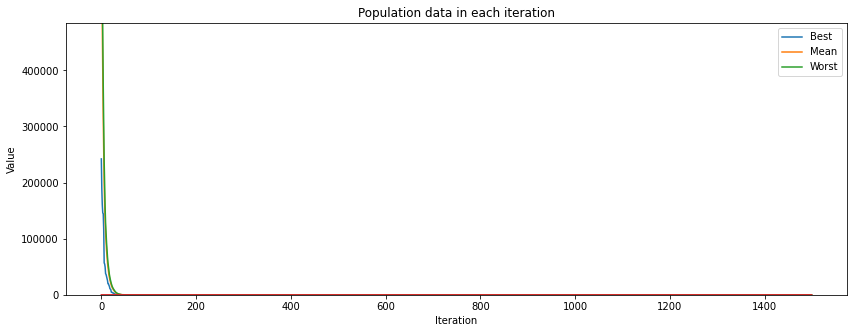

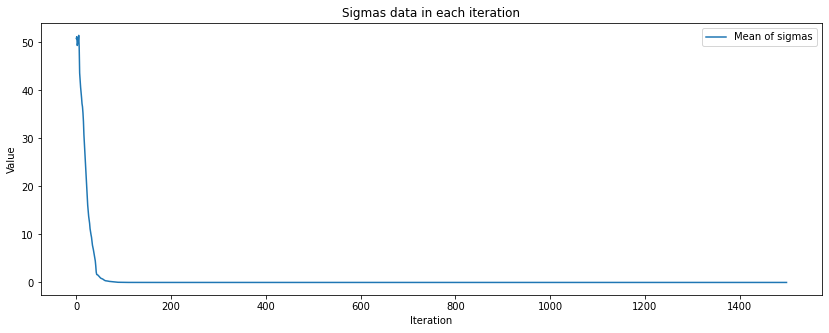

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, sum


Iteration 1. Current min:  3242207.334158234
Iteration 200. Current min:  204629.93188886644
Iteration 400. Current min:  18098.57968506239
Iteration 600. Current min:  744.1223510839986
Iteration 800. Current min:  190.71049340507392
Iteration 1000. Current min:  122.05364068553034
Iteration 1200. Current min:  12.789991174319065
Iteration 1400. Current min:  3.636697954662441
Iteration 1500. Current min:  3.3650246494143534



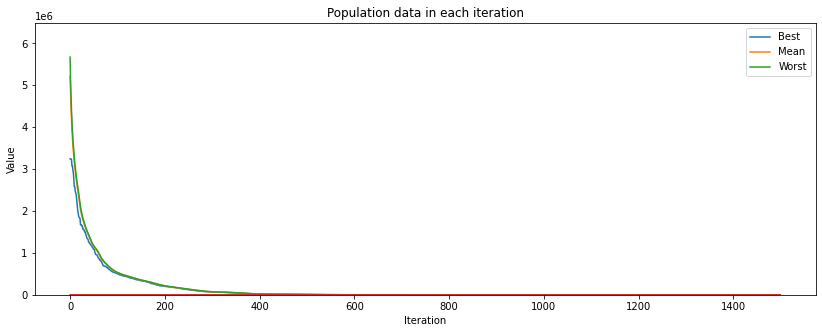

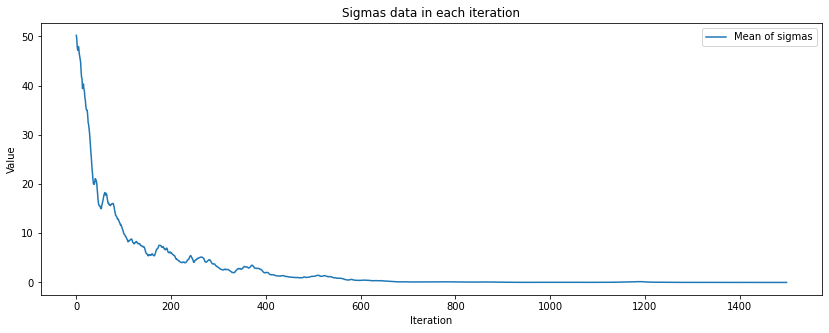

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, sum


Iteration 1. Current min:  8898727.761842757
Iteration 200. Current min:  1411203.8839276973
Iteration 400. Current min:  742645.7173340772
Iteration 600. Current min:  486122.8154867474
Iteration 800. Current min:  349226.172134179
Iteration 1000. Current min:  257016.051332542
Iteration 1200. Current min:  220285.20389013947
Iteration 1400. Current min:  93742.90052441333
Iteration 1500. Current min:  88818.8554612864



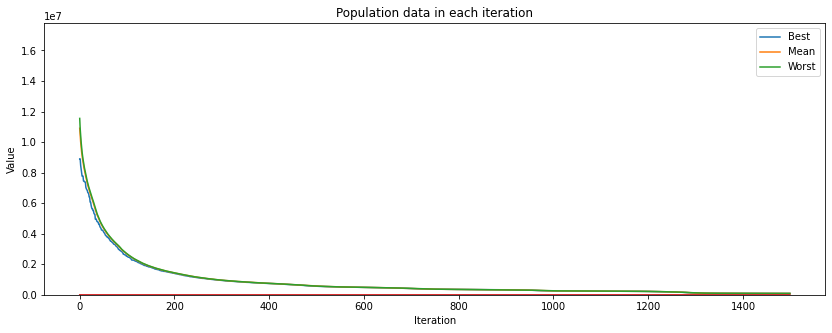

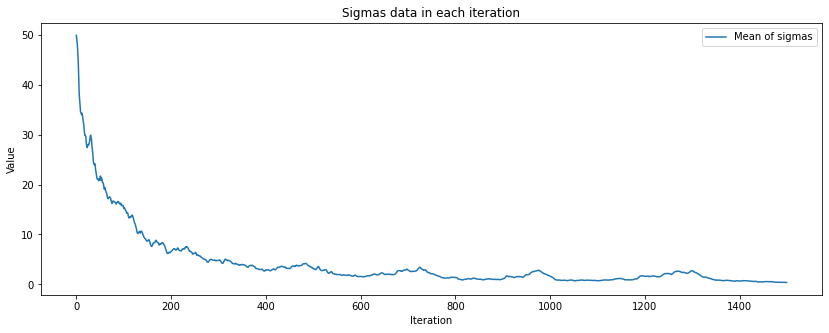

Mu, Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, just_offspring


Iteration 1. Current min:  315215.42239324434
Iteration 200. Current min:  0.00030612525312978534
Iteration 400. Current min:  0.0002500000000015268
Iteration 600. Current min:  0.0002500000000000835
Iteration 800. Current min:  0.0002500000000000835
Iteration 1000. Current min:  0.0002500000000000835
Iteration 1200. Current min:  0.0002500000000000835
Iteration 1400. Current min:  0.0002500000000000835
Iteration 1500. Current min:  0.0002500000000000835



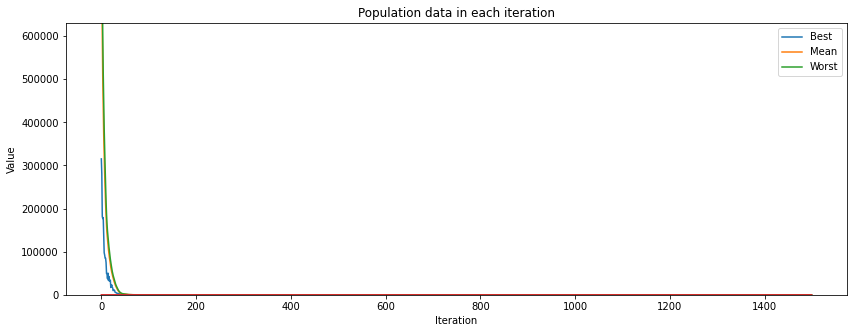

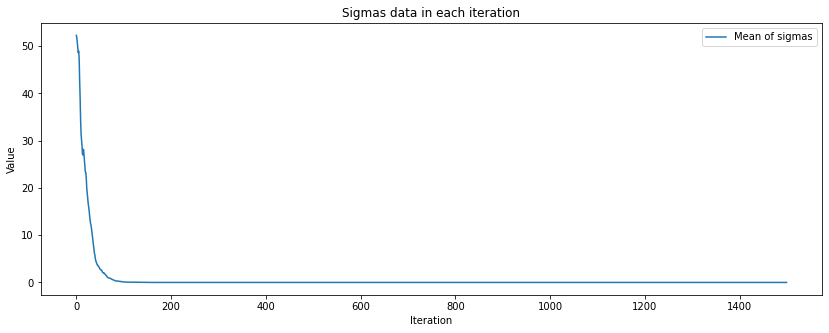

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, just_offspring


Iteration 1. Current min:  3470627.854877183
Iteration 200. Current min:  266822.93089196703
Iteration 400. Current min:  151596.2741259781
Iteration 600. Current min:  97179.00620434964
Iteration 800. Current min:  88595.48080816271
Iteration 1000. Current min:  87547.88379714654
Iteration 1200. Current min:  8215.313126000992
Iteration 1400. Current min:  1451.2851862130751
Iteration 1500. Current min:  1276.9222970107053



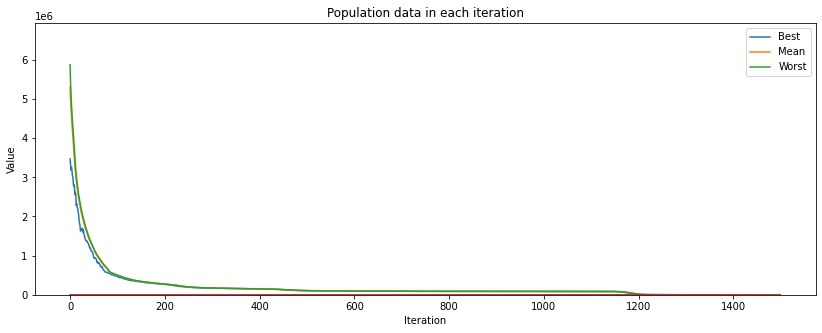

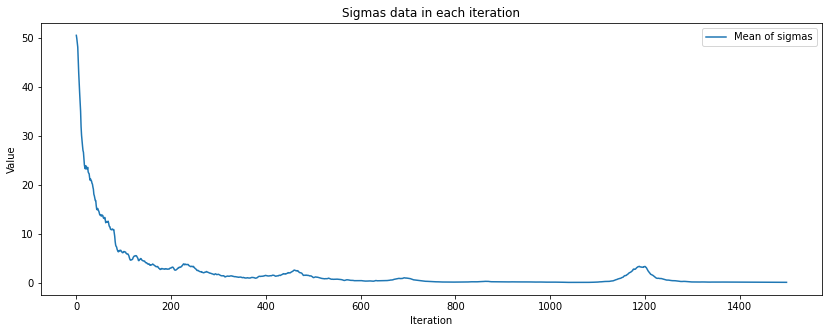

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, just_offspring


Iteration 1. Current min:  9069438.31138275
Iteration 200. Current min:  1704792.9772869307
Iteration 400. Current min:  963346.2076465178
Iteration 600. Current min:  772995.6349850997
Iteration 800. Current min:  526815.0380619171
Iteration 1000. Current min:  461773.2730535891
Iteration 1200. Current min:  421523.96804567706
Iteration 1400. Current min:  331430.1084926383
Iteration 1500. Current min:  317477.6861514293



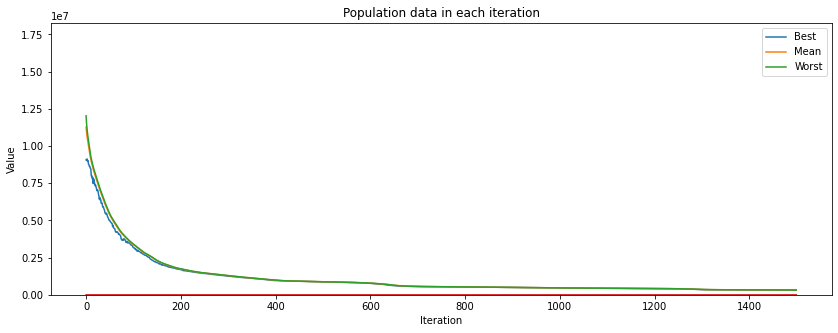

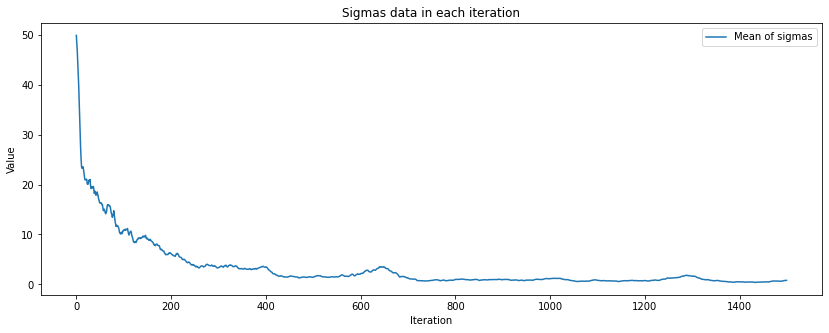

In [41]:
test(GriewankFunction, 'random', 1500)

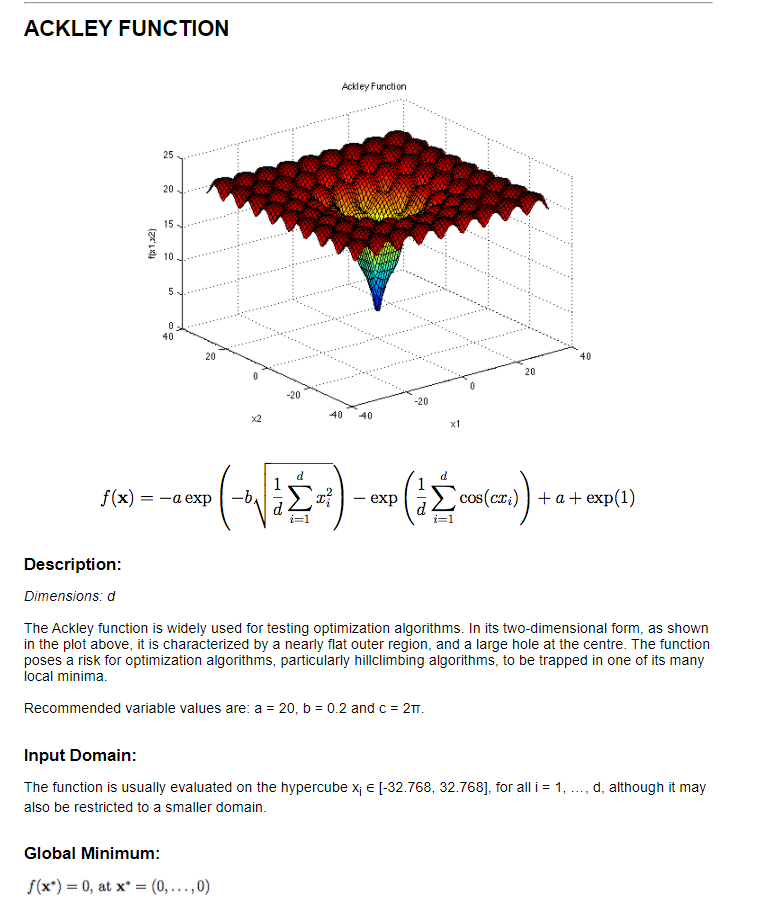

In [49]:
class AckleyFunction:
    low = -32
    high = 32
    low_sigma = 0
    high_sigma = 8
    
    def objective_function(ind):
        return (-20 * 
                np.exp(-0.2*np.sqrt(1/len(ind) * np.sum(ind**2))) - 
                np.exp(1 / len(ind) * np.sum(np.cos(2*np.pi*ind))) 
                + 20 + np.exp(1))
        
    def random_population(d, N):
        return np.random.uniform(low = AckleyFunction.low, high = AckleyFunction.high, size = (N, d))
    
    def random_sigmas_population(d, N):
        return np.random.uniform(high = AckleyFunction.high_sigma, size = (N, d))

Mu + Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, sum


Iteration 1. Current min:  18.79831706015624
Iteration 200. Current min:  0.0007796723490167348
Iteration 400. Current min:  0.0007796723490167348
Iteration 600. Current min:  0.0007796723490167348
Iteration 800. Current min:  0.0007796723490167348
Iteration 1000. Current min:  0.0007796723490167348
Iteration 1200. Current min:  0.0007796723490167348
Iteration 1400. Current min:  0.0007796723490167348
Iteration 1500. Current min:  0.0007796723490167348



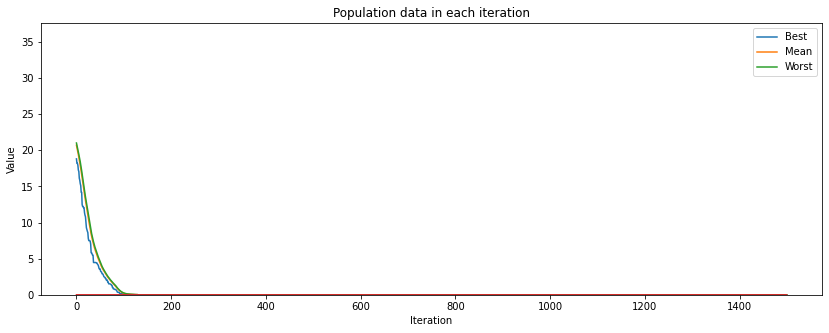

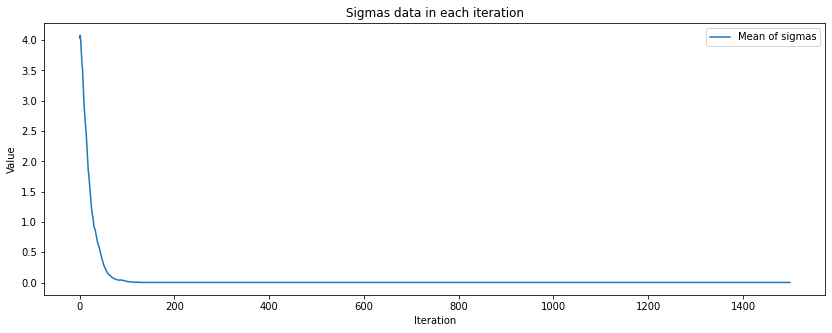

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, sum


Iteration 1. Current min:  20.393896210500273
Iteration 200. Current min:  11.944806750882876
Iteration 400. Current min:  0.0012491261994623266
Iteration 600. Current min:  0.0012491261994623266
Iteration 800. Current min:  0.0012491261994623266
Iteration 1000. Current min:  0.0012491261994623266
Iteration 1200. Current min:  0.0012491261994623266
Iteration 1400. Current min:  0.0012491261994623266
Iteration 1500. Current min:  0.0012491261994623266



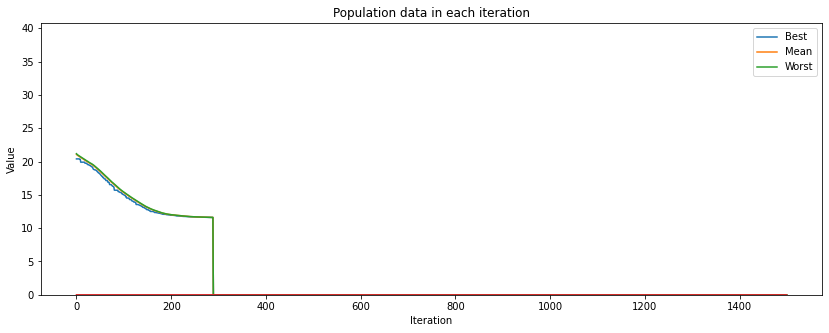

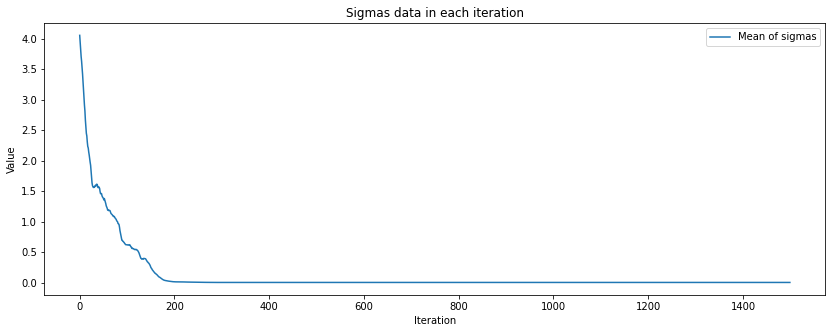

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, sum


Iteration 1. Current min:  20.706850804759505
Iteration 200. Current min:  17.26782508279122
Iteration 400. Current min:  0.0012493968059102364
Iteration 600. Current min:  0.0012493968059102364
Iteration 800. Current min:  0.0012493968059102364
Iteration 1000. Current min:  0.0012493968059102364
Iteration 1200. Current min:  0.0012493968059102364
Iteration 1400. Current min:  0.0012493968059102364
Iteration 1500. Current min:  0.0012493968059102364



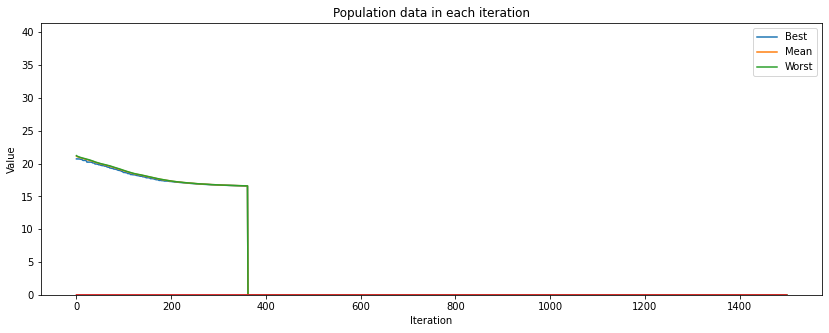

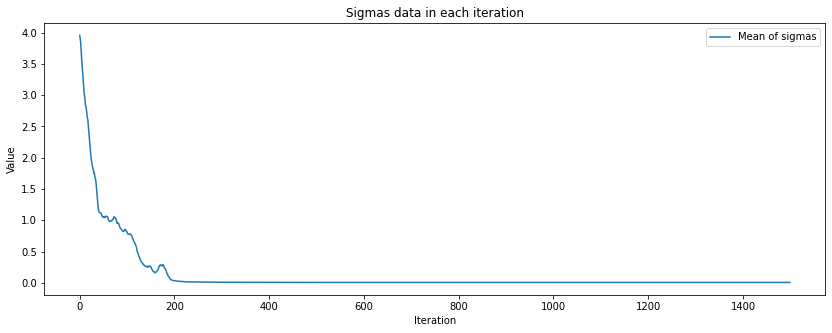

Mu, Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, just_offspring


Iteration 1. Current min:  18.99730791785697
Iteration 200. Current min:  0.10967124582403942
Iteration 400. Current min:  0.0002926532499718526
Iteration 600. Current min:  2.7919352607597148e-08
Iteration 800. Current min:  4.089617533509227e-12
Iteration 1000. Current min:  3.9968028886505635e-15
Iteration 1200. Current min:  3.9968028886505635e-15
Iteration 1400. Current min:  3.9968028886505635e-15
Iteration 1500. Current min:  3.9968028886505635e-15



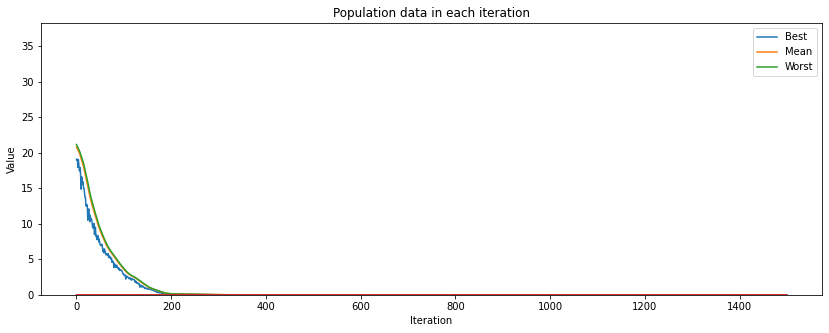

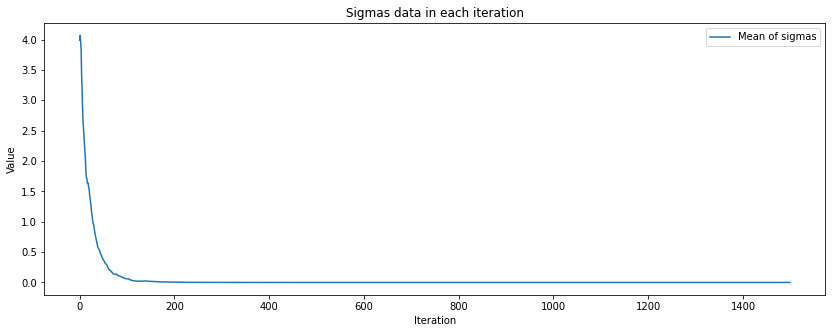

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, just_offspring


Iteration 1. Current min:  20.585406243587844
Iteration 200. Current min:  17.829905028682226
Iteration 400. Current min:  17.483957697103182
Iteration 600. Current min:  17.316775804003495
Iteration 800. Current min:  17.27673662221526
Iteration 1000. Current min:  17.24399536964569
Iteration 1200. Current min:  17.233203926316666
Iteration 1400. Current min:  17.135698546191815
Iteration 1500. Current min:  17.129787563903776



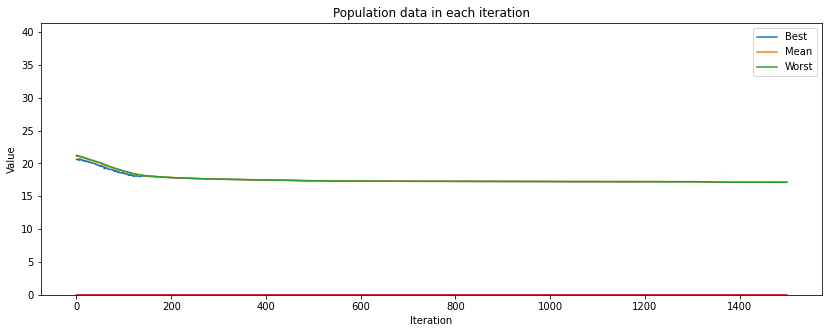

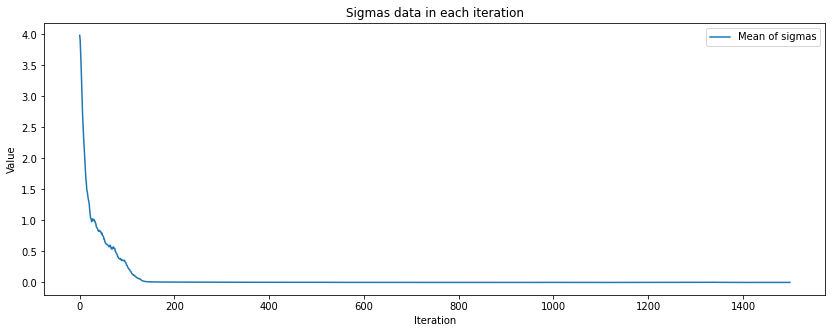

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, just_offspring


Iteration 1. Current min:  20.868824962732173
Iteration 200. Current min:  20.04133149969763
Iteration 400. Current min:  19.74513137469023
Iteration 600. Current min:  19.62037113595909
Iteration 800. Current min:  19.59956103779853
Iteration 1000. Current min:  19.566182689108356
Iteration 1200. Current min:  19.539601997561654
Iteration 1400. Current min:  19.48434756136486
Iteration 1500. Current min:  19.48018156004594



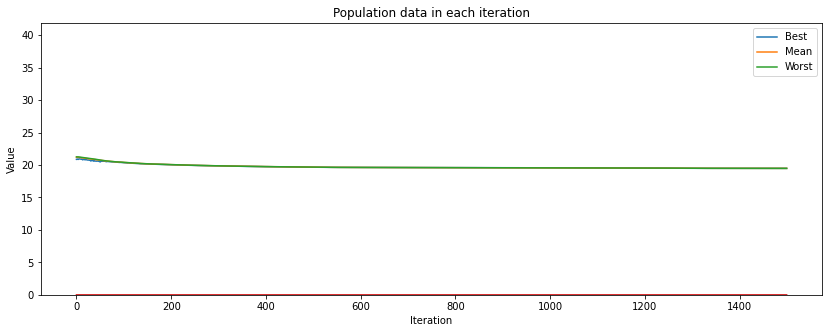

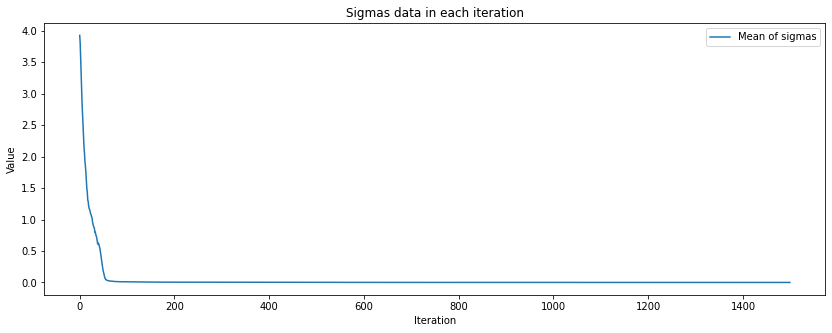

In [50]:
test(AckleyFunction, 'reversed_roulette', 1500)

Mu + Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, sum


Iteration 1. Current min:  17.57436924714362
Iteration 200. Current min:  3.1898794716767043e-10
Iteration 400. Current min:  3.9968028886505635e-15
Iteration 600. Current min:  3.9968028886505635e-15
Iteration 800. Current min:  3.9968028886505635e-15
Iteration 1000. Current min:  3.9968028886505635e-15
Iteration 1200. Current min:  3.9968028886505635e-15
Iteration 1400. Current min:  3.9968028886505635e-15
Iteration 1500. Current min:  3.9968028886505635e-15



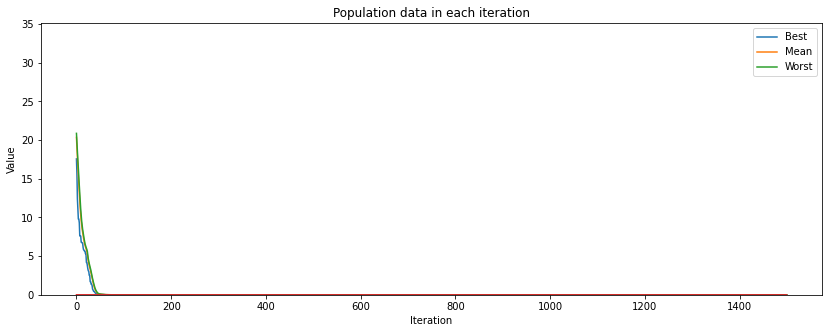

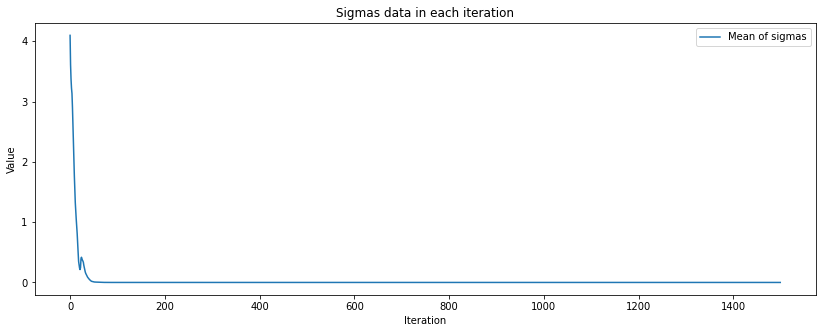

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, sum


Iteration 1. Current min:  20.130687986504615
Iteration 200. Current min:  11.086358656318753
Iteration 400. Current min:  11.066299434854857
Iteration 600. Current min:  11.065305858284498
Iteration 800. Current min:  11.065257768255702
Iteration 1000. Current min:  11.065196053180049
Iteration 1200. Current min:  11.065191075801147
Iteration 1400. Current min:  11.065182935624597
Iteration 1500. Current min:  11.06518289240616



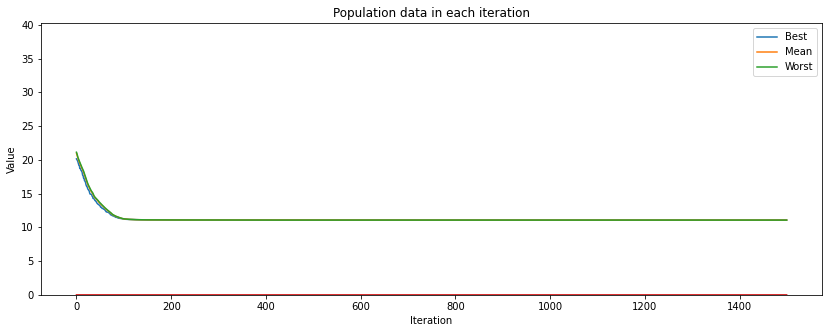

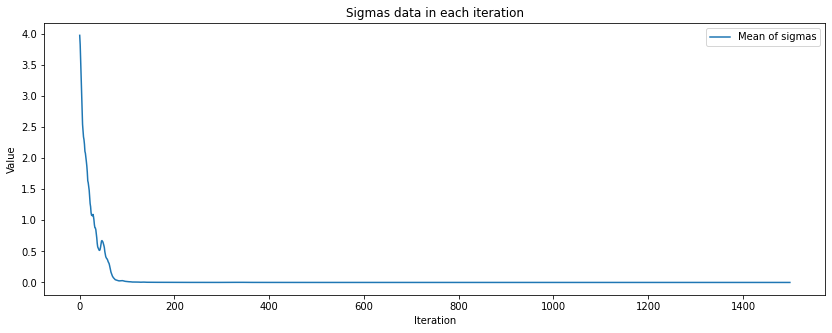

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, sum


Iteration 1. Current min:  20.825199040287977
Iteration 200. Current min:  15.175084610299848
Iteration 400. Current min:  15.05902768595939
Iteration 600. Current min:  15.02458052376025
Iteration 800. Current min:  14.995664377554636
Iteration 1000. Current min:  14.958645874348024
Iteration 1200. Current min:  14.939500623114647
Iteration 1400. Current min:  14.93570827979627
Iteration 1500. Current min:  14.933208471836762



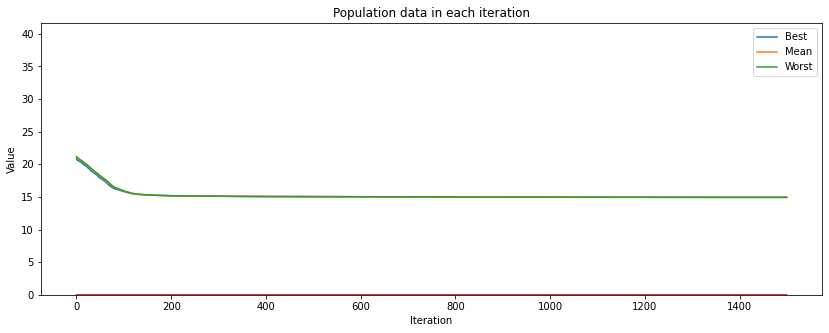

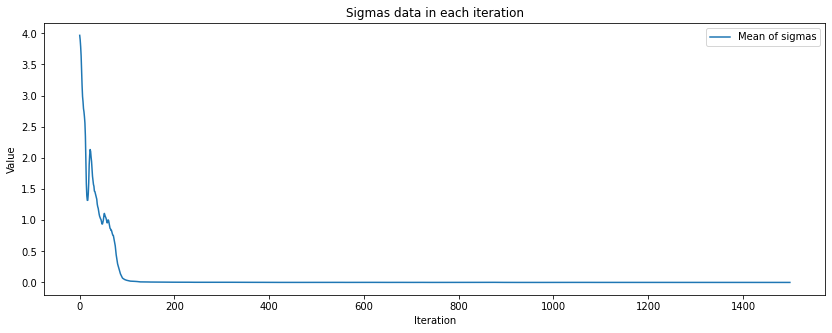

Mu, Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, just_offspring


Iteration 1. Current min:  17.2842639022858
Iteration 200. Current min:  1.0939249506236592e-11
Iteration 400. Current min:  3.9968028886505635e-15
Iteration 600. Current min:  3.9968028886505635e-15
Iteration 800. Current min:  3.9968028886505635e-15
Iteration 1000. Current min:  3.9968028886505635e-15
Iteration 1200. Current min:  3.9968028886505635e-15
Iteration 1400. Current min:  3.9968028886505635e-15
Iteration 1500. Current min:  3.9968028886505635e-15



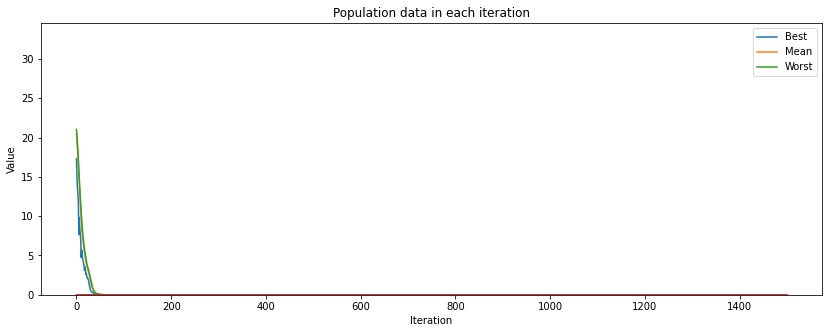

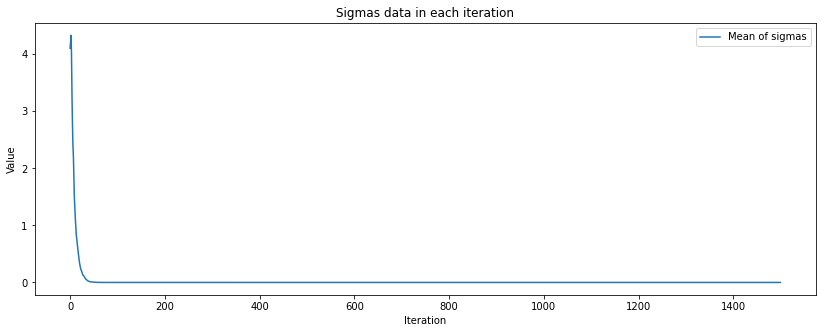

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, just_offspring


Iteration 1. Current min:  20.369432318361795
Iteration 200. Current min:  10.71235897624045
Iteration 400. Current min:  10.679227028201758
Iteration 600. Current min:  10.668479856399586
Iteration 800. Current min:  10.668086920574531
Iteration 1000. Current min:  10.664550287850004
Iteration 1200. Current min:  10.664536809799454
Iteration 1400. Current min:  10.664534963450548
Iteration 1500. Current min:  10.664534483603664



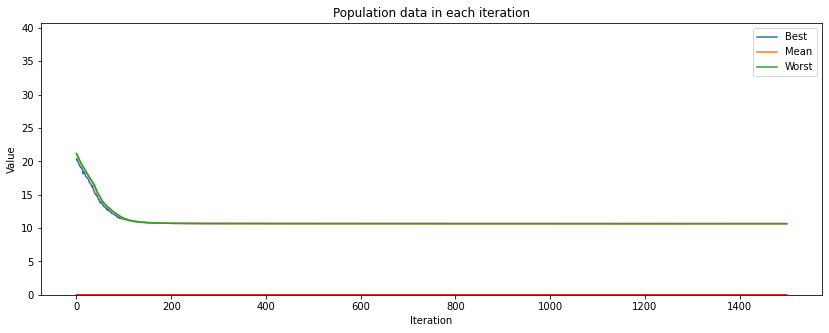

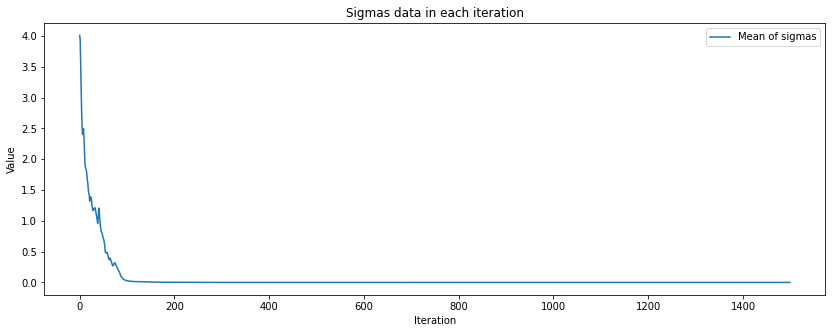

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, just_offspring


Iteration 1. Current min:  20.779959148205844
Iteration 200. Current min:  14.630716991058174
Iteration 400. Current min:  14.399157880885625
Iteration 600. Current min:  14.337216201577567
Iteration 800. Current min:  14.32509674900658
Iteration 1000. Current min:  14.320175573833193
Iteration 1200. Current min:  14.30920175806125
Iteration 1400. Current min:  14.30832664271787
Iteration 1500. Current min:  14.307648823422292



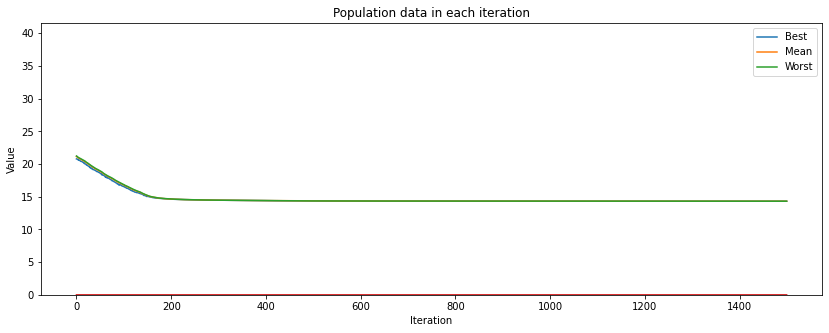

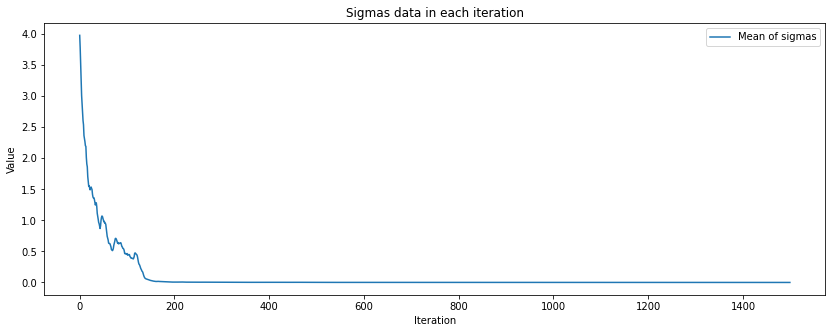

In [51]:
test(AckleyFunction, 'roulette', 1500)

Mu + Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, sum


Iteration 1. Current min:  18.029000570352938
Iteration 200. Current min:  1.2140116898429198e-06
Iteration 400. Current min:  2.1760371282653068e-14
Iteration 600. Current min:  3.9968028886505635e-15
Iteration 800. Current min:  3.9968028886505635e-15
Iteration 1000. Current min:  3.9968028886505635e-15
Iteration 1200. Current min:  3.9968028886505635e-15
Iteration 1400. Current min:  3.9968028886505635e-15
Iteration 1500. Current min:  3.9968028886505635e-15



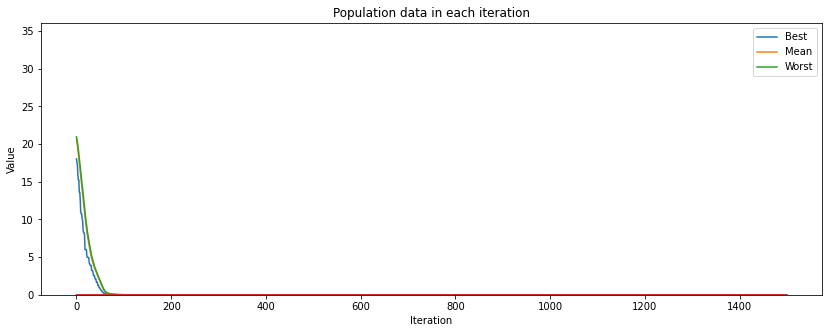

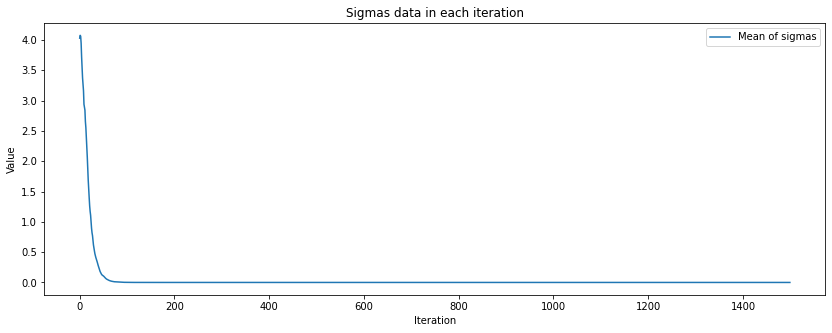

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, sum


Iteration 1. Current min:  20.30668933075122
Iteration 200. Current min:  13.324120362267536
Iteration 400. Current min:  13.112317593641214
Iteration 600. Current min:  13.100782635567802
Iteration 800. Current min:  13.099932107471965
Iteration 1000. Current min:  13.099755512513212
Iteration 1200. Current min:  13.09961622983953
Iteration 1400. Current min:  13.099611227650222
Iteration 1500. Current min:  13.099611003485807



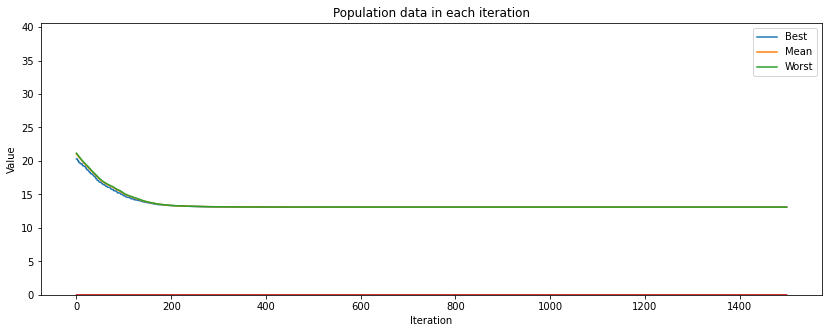

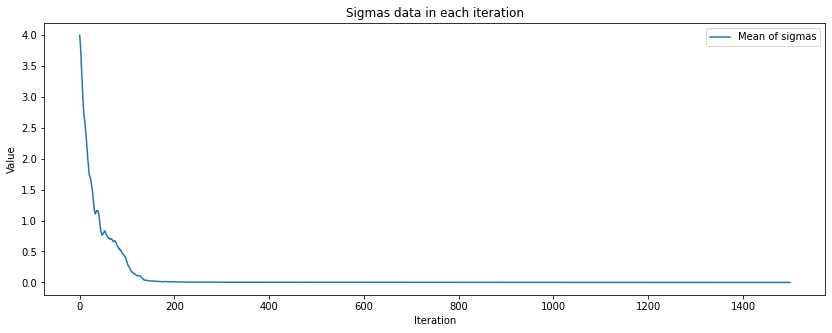

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, sum


Iteration 1. Current min:  20.744948625413247
Iteration 200. Current min:  15.541815097628188
Iteration 400. Current min:  14.838910149558053
Iteration 600. Current min:  14.71527240233026
Iteration 800. Current min:  14.658935919030183
Iteration 1000. Current min:  14.607330563321717
Iteration 1200. Current min:  14.597915455622193
Iteration 1400. Current min:  14.594729185309939
Iteration 1500. Current min:  14.581975495656783



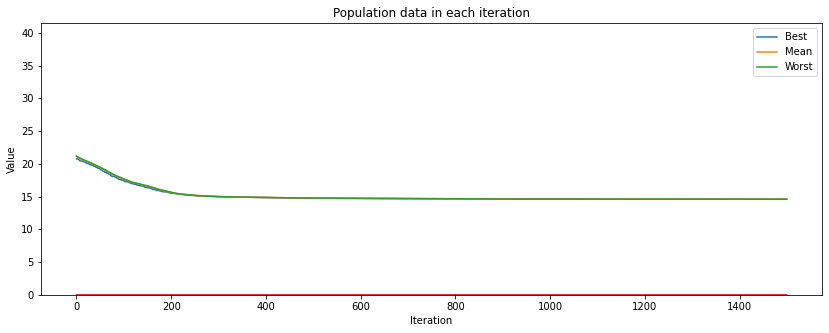

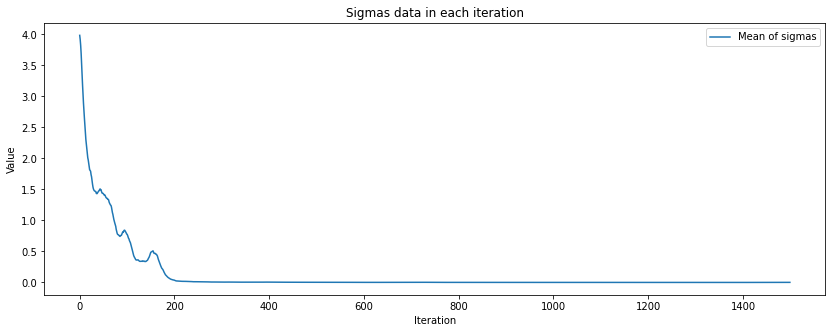

Mu, Lambda
no_iterations = 1500, mu = 800, l = 2000, d = 10, K = 0.6, just_offspring


Iteration 1. Current min:  18.859942628200763
Iteration 200. Current min:  1.6462278603406166
Iteration 400. Current min:  1.6462236331038373
Iteration 600. Current min:  1.646223633103109
Iteration 800. Current min:  1.646223633103109
Iteration 1000. Current min:  1.646223633103109
Iteration 1200. Current min:  1.646223633103109
Iteration 1400. Current min:  1.646223633103109
Iteration 1500. Current min:  1.646223633103109



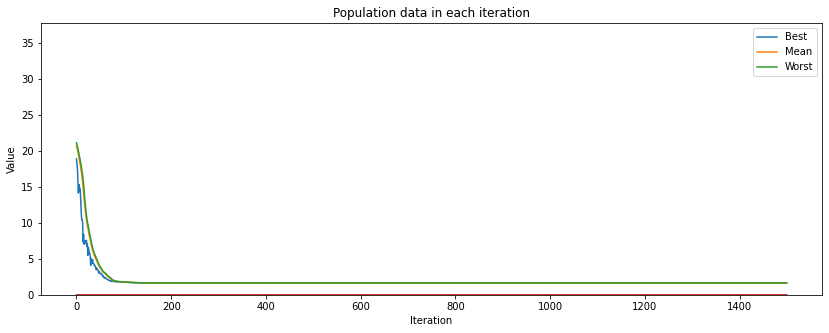

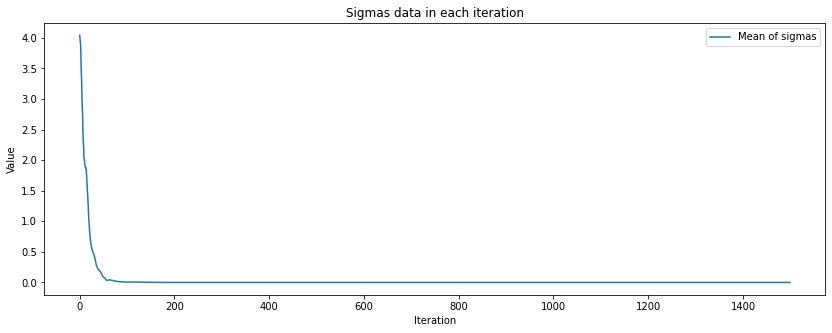

no_iterations = 1500, mu = 800, l = 2000, d = 50, K = 0.6, just_offspring


Iteration 1. Current min:  20.498410060073283
Iteration 200. Current min:  15.699262089518953
Iteration 400. Current min:  15.527380219023462
Iteration 600. Current min:  15.486685970330374
Iteration 800. Current min:  15.44717509550787
Iteration 1000. Current min:  15.444414260648891
Iteration 1200. Current min:  15.434202661676034
Iteration 1400. Current min:  15.433512108898837
Iteration 1500. Current min:  15.433488461915722



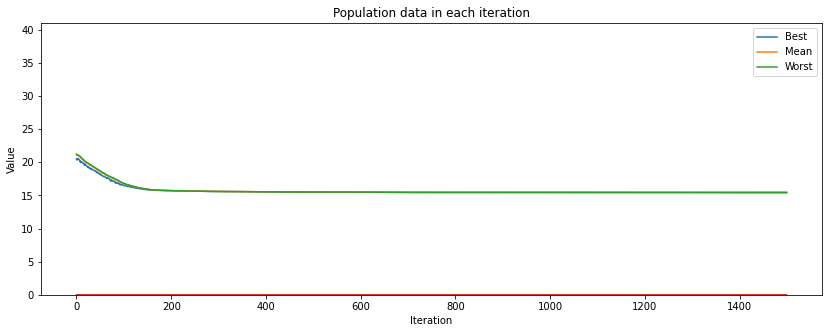

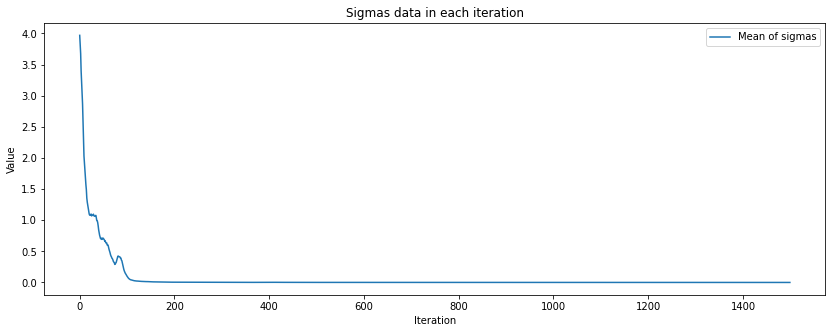

no_iterations = 1500, mu = 800, l = 2000, d = 100, K = 0.6, just_offspring


Iteration 1. Current min:  20.880555222328123
Iteration 200. Current min:  19.093122120757645
Iteration 400. Current min:  18.86142730205016
Iteration 600. Current min:  18.794585391261894
Iteration 800. Current min:  18.777027728778965
Iteration 1000. Current min:  18.756452710319724
Iteration 1200. Current min:  18.711916785460186
Iteration 1400. Current min:  18.70279683858357
Iteration 1500. Current min:  18.661041282043577



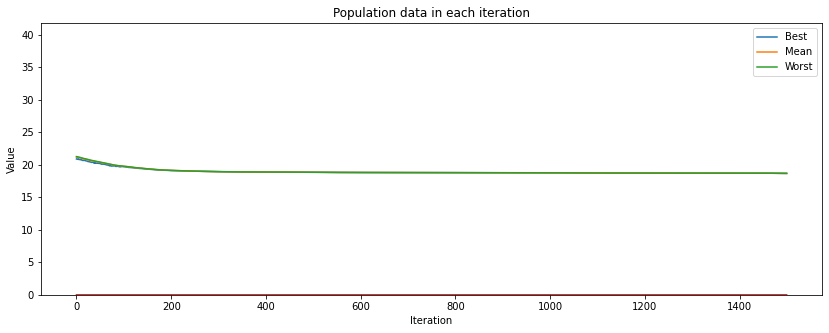

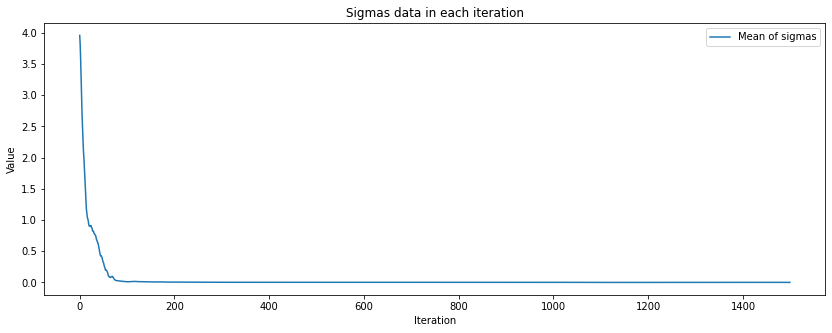

In [52]:
test(AckleyFunction, 'random', 1500)

# 